<a href="https://colab.research.google.com/github/rtrochepy/machine_learning/blob/main/Missing_Data_Handling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Missing Data Handling Course - Detection and Exploration**

Instructor: Jesus Velez Santiago

**Workspace setup**

In [1]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [2]:
!pip install pyjanitor matplotlib==3.5.1 missingno numpy pandas pyreadr seaborn session-info upsetplot==0.6.1

  Obtaining dependency information for pyjanitor from https://files.pythonhosted.org/packages/a8/ae/0a0287a4bbc8be4158c25d86a096feff13e8ae1564e9fcdb3c4cb997b712/pyjanitor-0.25.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 30.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for pandas-flavor from https://files.pythonhosted.org/packages/67/1a/bfb5574b215f530c7ac5be684f33d60b299abbebd763c203aa31755f2fb2/pandas_flavor-0.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for stdlib_list from https://files.pythonhosted.org/packages/be/f4/08daf83c6414031b46e883cb5e06286077e52e8e2f1ae4b3662819a211aa/stdlib_list-0.9.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.3/171.3 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6

In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=23b1455723025828288a6bea9d9a45814ac32c0cc18d77885c27c4154987dea5
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


**Import libraries**

In [5]:
import os
import janitor
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns
import session_info
import upsetplot
import itertools

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
try:
    del pd.DataFrame.missing
except AttributeError:
    pass

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
@pd.api.extensions.register_dataframe_accessor("missing")
class MissingMethods:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def number_missing(self) -> int:
        return self._obj.isna().sum().sum()

    def number_complete(self) -> int:
        return self._obj.size - self._obj.missing.number_missing()

    def missing_variable_summary(self) -> pd.DataFrame:
        return self._obj.isnull().pipe(
            lambda df_1: (
                df_1.sum()
                .reset_index(name="n_missing")
                .rename(columns={"index": "variable"})
                .assign(
                    n_cases=len(df_1),
                    pct_missing=lambda df_2: df_2.n_missing / df_2.n_cases * 100,
                )
            )
        )

    def missing_case_summary(self) -> pd.DataFrame:
        return self._obj.assign(
            case=lambda df: df.index,
            n_missing=lambda df: df.apply(
                axis="columns", func=lambda row: row.isna().sum()
            ),
            pct_missing=lambda df: df["n_missing"] / df.shape[1] * 100,
        )[["case", "n_missing", "pct_missing"]]

    def missing_variable_table(self) -> pd.DataFrame:
        return (
            self._obj.missing.missing_variable_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_variable", 0: "n_variables"})
            .assign(
                pct_variables=lambda df: df.n_variables / df.n_variables.sum() * 100
            )
            .sort_values("pct_variables", ascending=False)
        )

    def missing_case_table(self) -> pd.DataFrame():
        return (
            self._obj.missing.missing_case_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_case", 0: "n_cases"})
            .assign(pct_case=lambda df: df.n_cases / df.n_cases.sum() * 100)
            .sort_values("pct_case", ascending=False)
        )

    def missing_variable_span(self, variable: str, span_every: int) -> pd.DataFrame:
        return (
            self._obj.assign(
                span_counter=lambda df: (
                    np.repeat(a=range(df.shape[0]), repeats=span_every)[: df.shape[0]]
                )
            )
            .groupby("span_counter")
            .aggregate(
                n_in_span=(variable, "size"),
                n_missing=(variable, lambda s: s.isnull().sum()),
            )
            .assign(
                n_complete=lambda df: df.n_in_span - df.n_missing,
                pct_missing=lambda df: df.n_missing / df.n_in_span * 100,
                pct_complete=lambda df: 100 - df.pct_missing,
            )
            .drop(columns=["n_in_span"])
            .reset_index()
        )

    def missing_variable_run(self, variable) -> pd.DataFrame:
        rle_list = self._obj[variable].pipe(
            lambda s: [[len(list(g)), k] for k, g in itertools.groupby(s.isnull())]
        )

        return pd.DataFrame(data=rle_list, columns=["run_length", "is_na"]).replace(
            {False: "complete", True: "missing"}
        )

    def sort_variables_by_missingness(self, ascending = False):

        return (
            self._obj
            .pipe(
                lambda df: (
                    df[df.isna().sum().sort_values(ascending = ascending).index]
                )
            )
        )

    def create_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        return (
            self._obj
            .isna()
            .pipe(lambda df: df[df.columns[df.any()]] if only_missing else df)
            .replace({False: false_string, True: true_string})
            .add_suffix("_NA")
        )

    def bind_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        return pd.concat(
            objs=[
                self._obj,
                self._obj.missing.create_shadow_matrix(
                    true_string=true_string,
                    false_string=false_string,
                    only_missing=only_missing
                )
            ],
            axis="columns"
        )

    def missing_scan_count(self, search) -> pd.DataFrame:
        return (
            self._obj.apply(axis="rows", func=lambda column: column.isin(search))
            .sum()
            .reset_index()
            .rename(columns={"index": "variable", 0: "n"})
            .assign(original_type=self._obj.dtypes.reset_index()[0])
        )

    # Plotting functions ---

    def missing_variable_plot(self):
        df = self._obj.missing.missing_variable_summary().sort_values("n_missing")

        plot_range = range(1, len(df.index) + 1)

        plt.hlines(y=plot_range, xmin=0, xmax=df.n_missing, color="black")

        plt.plot(df.n_missing, plot_range, "o", color="black")

        plt.yticks(plot_range, df.variable)

        plt.grid(axis="y")

        plt.xlabel("Number missing")
        plt.ylabel("Variable")

    def missing_case_plot(self):

        df = self._obj.missing.missing_case_summary()

        sns.displot(data=df, x="n_missing", binwidth=1, color="black")

        plt.grid(axis="x")
        plt.xlabel("Number of missings in case")
        plt.ylabel("Number of cases")

    def missing_variable_span_plot(
        self, variable: str, span_every: int, rot: int = 0, figsize=None
    ):

        (
            self._obj.missing.missing_variable_span(
                variable=variable, span_every=span_every
            ).plot.bar(
                x="span_counter",
                y=["pct_missing", "pct_complete"],
                stacked=True,
                width=1,
                color=["black", "lightgray"],
                rot=rot,
                figsize=figsize,
            )
        )

        plt.xlabel("Span number")
        plt.ylabel("Percentage missing")
        plt.legend(["Missing", "Present"])
        plt.title(
            f"Percentage of missing values\nOver a repeating span of { span_every } ",
            loc="left",
        )
        plt.grid(False)
        plt.margins(0)
        plt.tight_layout(pad=0)

    def missing_upsetplot(self, variables: list[str] = None, **kwargs):

        if variables is None:
            variables = self._obj.columns.tolist()

        return (
            self._obj.isna()
            .value_counts(variables)
            .pipe(lambda df: upsetplot.plot(df, **kwargs))
        )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (10, 10)
    }
)

sns.set_style("whitegrid")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
print(
    np.nan or True,
    np.nan or False,
    np.nan == np.nan,
    np.nan is np.nan,
    np.nan / 2,
    np.nan * 7,
    type(np.nan),
    np.isnan(np.nan),
    sep="\n"
)

nan
nan
False
True
nan
nan
<class 'float'>
True


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
test_missing_df = pd.DataFrame.from_dict(
    data=dict(
        x=[0, 1, np.nan, np.nan, None],
        y=[0, 1, pd.NA, np.nan, None]
    )
)

test_missing_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,x,y
0,0.0,0
1,1.0,1
2,NaN,<NA>
3,NaN,NaN
4,NaN,None


In [11]:
test_missing_df.isna()
test_missing_df.isnull()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,x,y
0,False,False
1,False,False
2,True,True
3,True,True
4,True,True


In [12]:
test_missing_df.x.isnull()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    False
1    False
2     True
3     True
4     True
Name: x, dtype: bool

In [14]:
pd.Series([1, np.nan])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    1.0
1    NaN
dtype: float64

In [15]:
pd.Series([pd.to_datetime("2022-01-01"), np.nan])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0   2022-01-01
1          NaT
dtype: datetime64[ns]

In [16]:
pd.Series([-1]).isnull()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    False
dtype: bool

**Load datasets**

### Pima Indians Diabetes

In [17]:
pima_indians_diabetes_url = "https://nrvis.com/data/mldata/pima-indians-diabetes.csv"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
#!wget -O ./data/pima-indians-diabetes.csv { pima_indians_diabetes_url } -q
!wget "https://nrvis.com/data/mldata/pima-indians-diabetes.csv"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--2023-08-05 02:18:12--  https://nrvis.com/data/mldata/pima-indians-diabetes.csv
Resolving nrvis.com (nrvis.com)... 173.236.176.48
Connecting to nrvis.com (nrvis.com)|173.236.176.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23279 (23K) [text/csv]
Saving to: ‘pima-indians-diabetes.csv’

pima-indians-diabet 100%[===================>]  22.73K  --.-KB/s    in 0.07s   

2023-08-05 02:18:12 (326 KB/s) - ‘pima-indians-diabetes.csv’ saved [23279/23279]



In [19]:
diabetes_df = pd.read_csv(
    filepath_or_buffer="./pima-indians-diabetes.csv", # or pima_indians_diabetes_url
    sep=",",
    names=[
        "pregnancies",
        "glucose",
        "blood_pressure",
        "skin_thickness",
        "insulin",
        "bmi",
        "diabetes_pedigree_function",
        "age",
        "outcome",
    ]
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**naniar (oceanbuoys, pedestrian, riskfactors)**

Creating data set units of **information**

In [20]:
base_url = "https://github.com/njtierney/naniar/raw/master/data/"
datasets_names = ("oceanbuoys", "pedestrian", "riskfactors")
extension = ".rda"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Downloading and loading datasets**

In [21]:
datasets_dfs = {}

for dataset_name in datasets_names:

    dataset_file = f"{ dataset_name }{ extension }"
    dataset_output_file = f"./{ dataset_file }"
    dataset_url = f"{ base_url }{ dataset_file }"

    !wget -q -O { dataset_output_file } { dataset_url }

    datasets_dfs[f"{ dataset_name }_df"] = pyreadr.read_r(dataset_output_file).get(dataset_name)

datasets_dfs.keys()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['oceanbuoys_df', 'pedestrian_df', 'riskfactors_df'])

**Including datasets in our local environment**

In [22]:
locals().update(**datasets_dfs)
del datasets_dfs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Verify loading**

In [23]:
oceanbuoys_df.shape, pedestrian_df.shape, riskfactors_df.shape, diabetes_df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((736, 8), (37700, 9), (245, 34), (768, 9))

In [24]:
riskfactors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   state             245 non-null    category
 1   sex               245 non-null    category
 2   age               245 non-null    int32   
 3   weight_lbs        235 non-null    object  
 4   height_inch       243 non-null    object  
 5   bmi               234 non-null    float64 
 6   marital           244 non-null    category
 7   pregnant          30 non-null     category
 8   children          245 non-null    int32   
 9   education         244 non-null    category
 10  employment        245 non-null    category
 11  income            245 non-null    category
 12  veteran           242 non-null    category
 13  hispanic          243 non-null    category
 14  health_general    245 non-null    category
 15  health_physical   245 non-null    int32   
 16  health_mental     245 non-

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Tabulation of missing values**

In [25]:
riskfactors_df.isna()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
241,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
242,False,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
243,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False


**Basic summaries of missing values**

In [26]:
riskfactors_df.shape

riskfactors_df.missing.number_complete()


riskfactors_df.missing.number_missing()

riskfactors_df.missing.missing_variable_summary()

riskfactors_df.missing.missing_variable_table()

riskfactors_df.missing.missing_case_summary()

riskfactors_df.missing.missing_case_table()

(
    riskfactors_df
    .missing
    .missing_variable_span(
        variable="weight_lbs",
        span_every=50
    )
)

(
    riskfactors_df
    .missing
    .missing_variable_run(
        variable="weight_lbs"
    )
)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,run_length,is_na
0,14,complete
1,1,missing
2,45,complete
3,1,missing
4,5,complete
5,1,missing
6,12,complete
7,1,missing
8,10,complete
9,2,missing


**Total number of complete values (without missing observations)**

In [27]:
riskfactors_df.missing.number_complete()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7144

**Total number of missing values**

In [28]:
riskfactors_df.missing.number_missing()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1186

**Tabular summaries of missing values**

**Summary by variable**

In [29]:
riskfactors_df.missing.missing_variable_summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,variable,n_missing,n_cases,pct_missing
0,state,0,245,0.000000
1,sex,0,245,0.000000
2,age,0,245,0.000000
3,weight_lbs,10,245,4.081633
4,height_inch,2,245,0.816327
5,bmi,11,245,4.489796
6,marital,1,245,0.408163
7,pregnant,215,245,87.755102
8,children,0,245,0.000000
9,education,1,245,0.408163


**Tabulation of summary by variable**

In [30]:
riskfactors_df.missing.missing_variable_table()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,n_missing_in_variable,n_variables,pct_variables
0,0,10,29.411765
1,8,6,17.647059
2,2,4,11.764706
3,3,3,8.823529
4,1,2,5.882353
5,10,1,2.941176
6,11,1,2.941176
7,113,1,2.941176
8,128,1,2.941176
9,134,1,2.941176


**Cases / Observations / Rows**

**Summaries per case**

In [31]:
riskfactors_df.missing.missing_case_summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,case,n_missing,pct_missing
0,0,6,16.666667
1,1,6,16.666667
2,2,7,19.444444
3,3,12,33.333333
4,4,5,13.888889
...,...,...,...
240,240,6,16.666667
241,241,5,13.888889
242,242,3,8.333333
243,243,2,5.555556


**Tabulation of summaries per case**

In [ ]:
riskfactors_df.missing.missing_case_table()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,n_missing_in_case,n_cases,pct_case
0,4,49,20.000000
1,5,45,18.367347
2,7,39,15.918367
3,6,36,14.693878
4,2,31,12.653061
5,3,30,12.244898
6,1,4,1.632653
7,8,3,1.224490
8,12,3,1.224490
9,15,2,0.816327


**Intervals of missing values**

In [32]:
(
    riskfactors_df
    .missing
    .missing_variable_span(
        variable="weight_lbs",
        span_every=50
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,span_counter,n_missing,n_complete,pct_missing,pct_complete
0,0,1,49,2.000000,98.000000
1,1,5,45,10.000000,90.000000
2,2,1,49,2.000000,98.000000
3,3,1,49,2.000000,98.000000
4,4,2,43,4.444444,95.555556


**_Run length_ of missing values**

In [33]:
(
    riskfactors_df
    .missing
    .missing_variable_run(
        variable="weight_lbs"
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,run_length,is_na
0,14,complete
1,1,missing
2,45,complete
3,1,missing
4,5,complete
5,1,missing
6,12,complete
7,1,missing
8,10,complete
9,2,missing


**Initial visualization of missing values**

**Variable**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


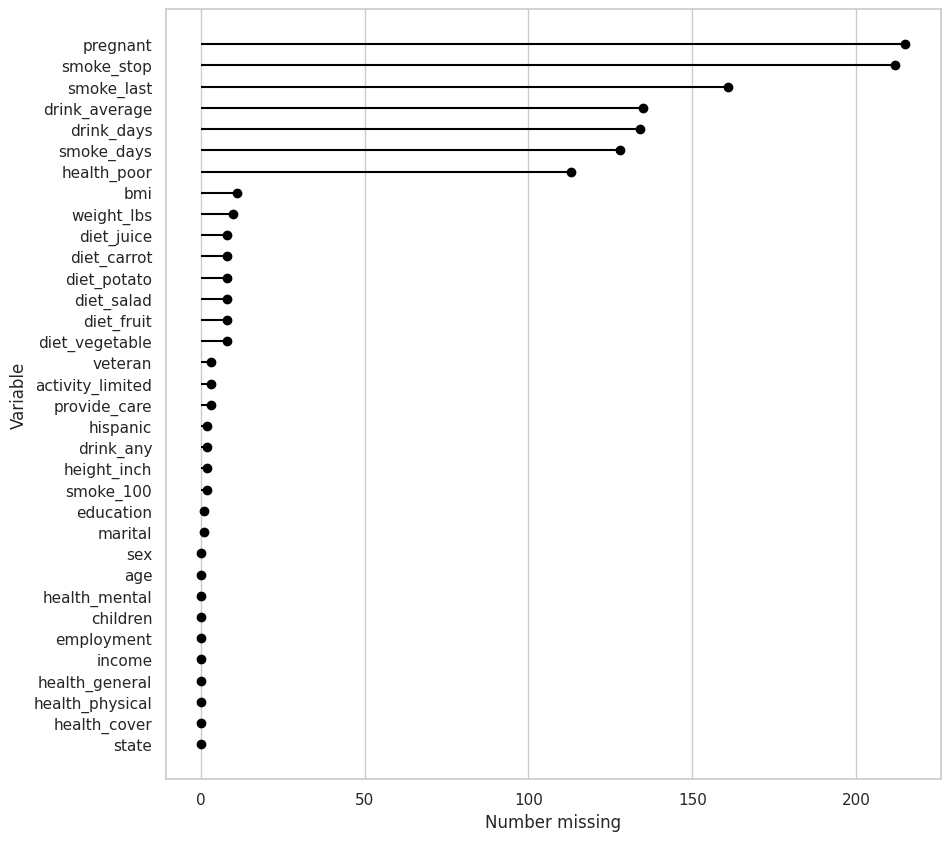

In [34]:
riskfactors_df.missing.missing_variable_plot()

**Cases / Observations / Rows**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


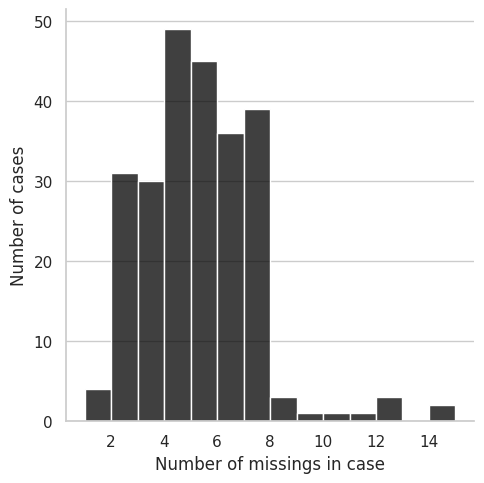

In [35]:
riskfactors_df.missing.missing_case_plot()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


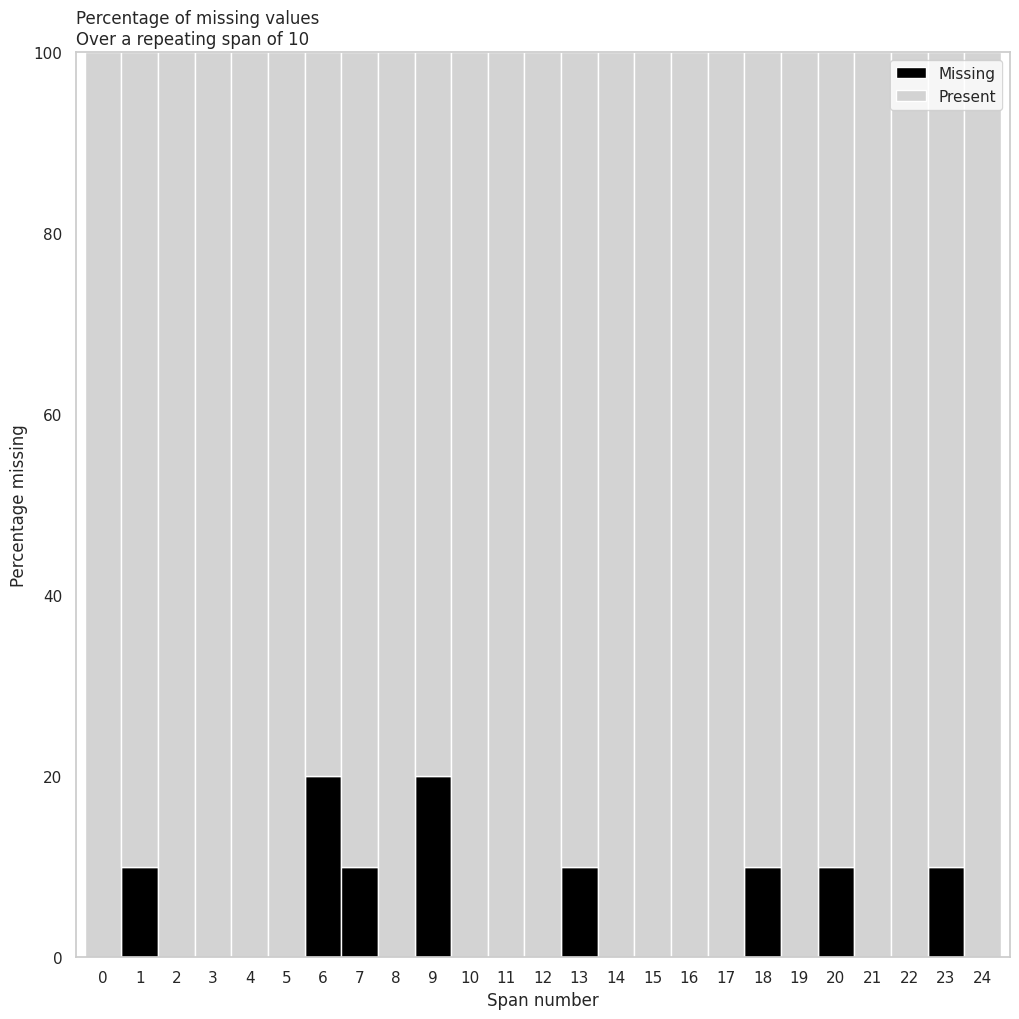

In [36]:
(
    riskfactors_df
    .missing
    .missing_variable_span_plot(
        variable="weight_lbs",
        span_every=10,
        rot=0
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

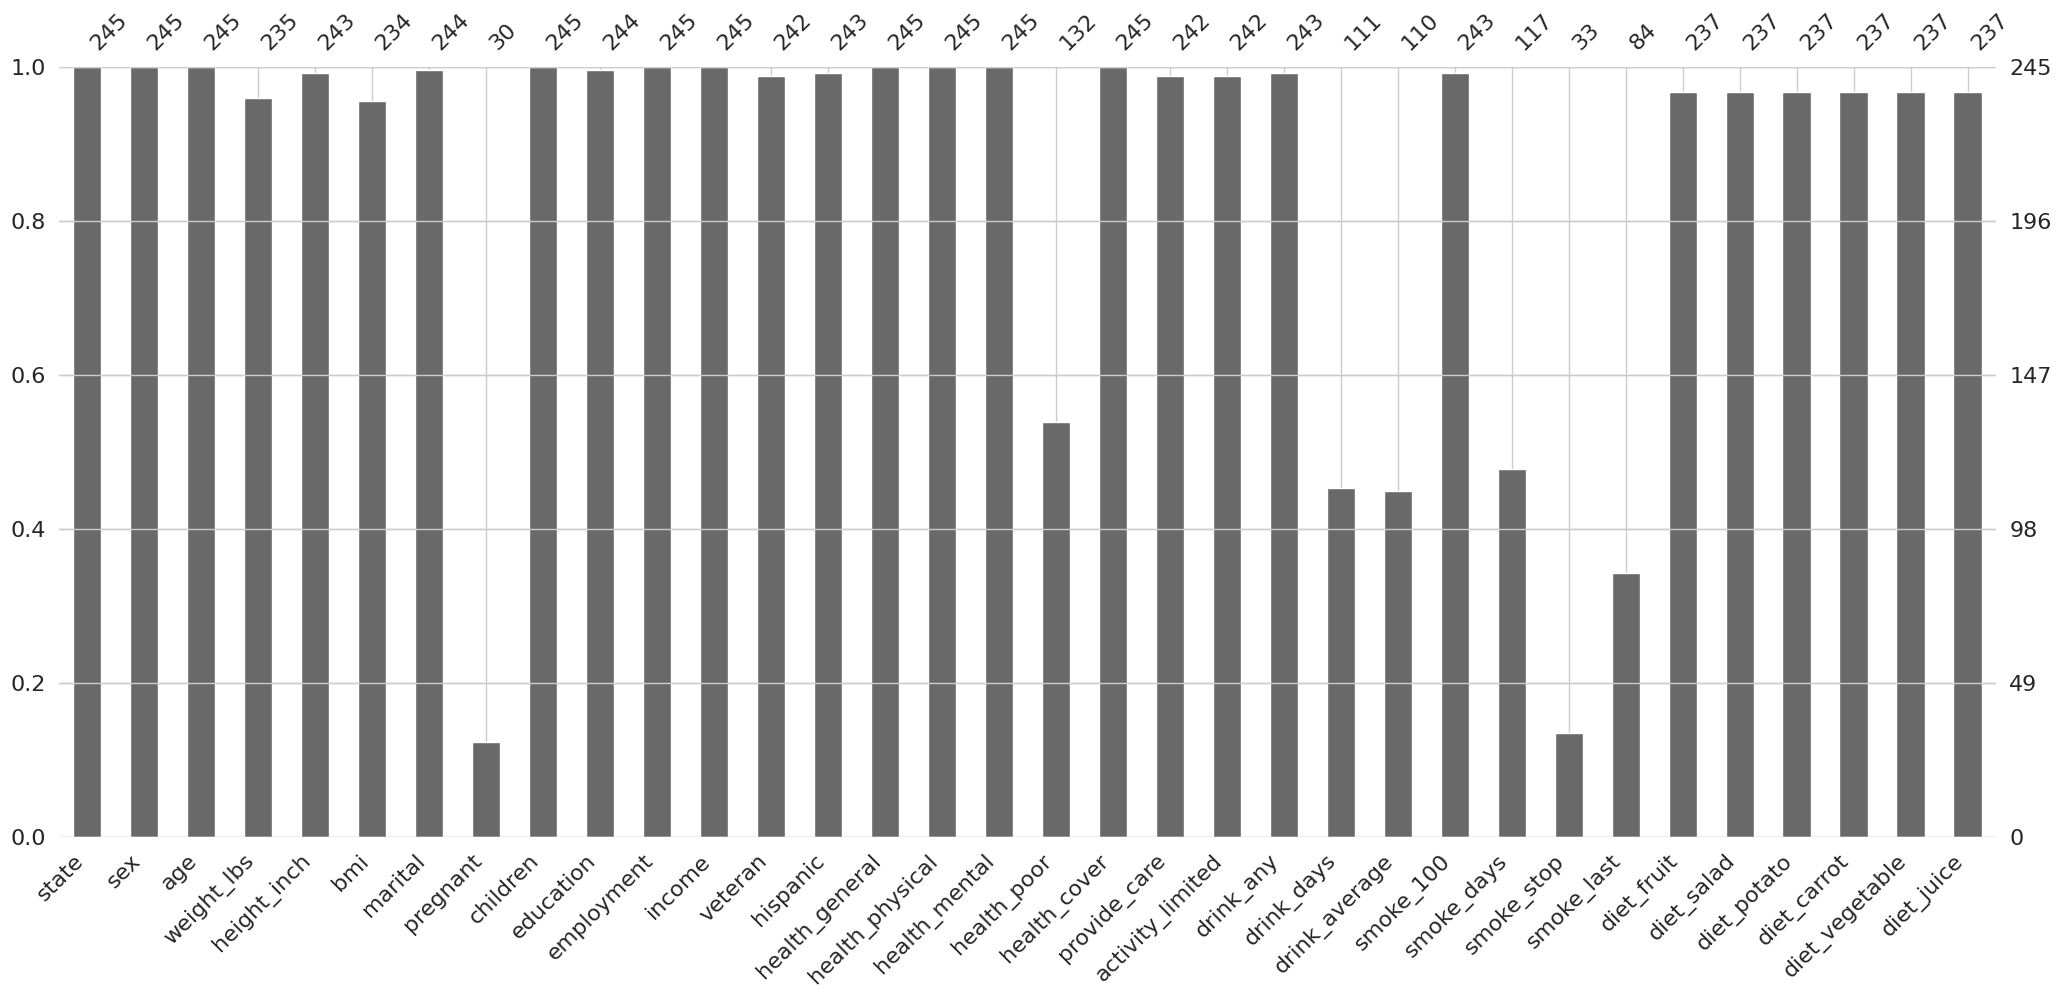

In [37]:
missingno.bar(df = riskfactors_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

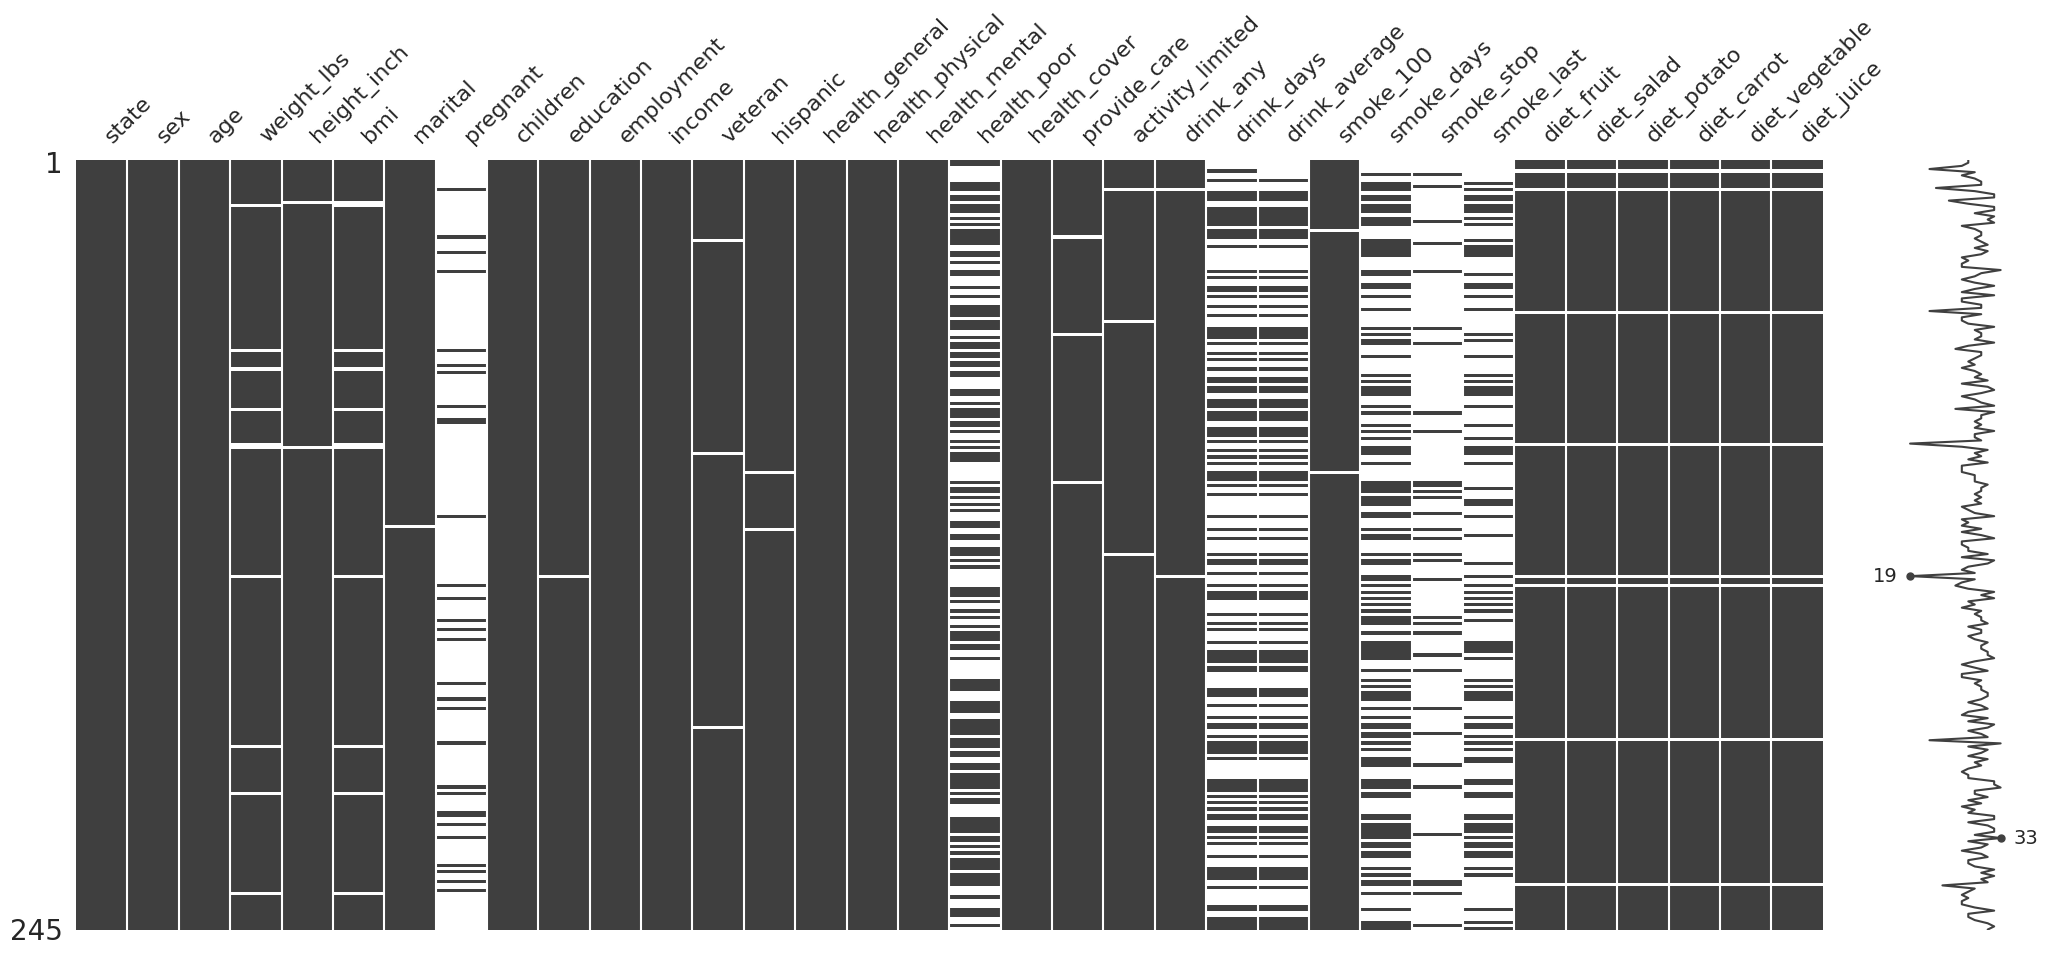

In [38]:
missingno.matrix(df=riskfactors_df)

In [40]:
(
    riskfactors_df
    .missing
    .missing_upsetplot(
        variables = None,
        element_size = 60
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: ignored

<Figure size 1000x600 with 0 Axes>

**Values commonly associated with missing values**

**Text strings**

In [41]:
common_na_strings = (
    "missing",
    "NA",
    "N A",
    "N/A",
    "#N/A",
    "NA ",
    " NA",
    "N /A",
    "N / A",
    " N / A",
    "N / A ",
    "na",
    "n a",
    "n/a",
    "na ",
    " na",
    "n /a",
    "n / a",
    " a / a",
    "n / a ",
    "NULL",
    "null",
    "",
    "?",
    "*",
    ".",
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Numbers**

In [42]:
common_na_numbers = (-9, -99, -999, -9999, 9999, 66, 77, 88, -1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**How to find values commonly associated with missing values?**

In [43]:
missing_data_example_df = pd.DataFrame.from_dict(
    dict(
        x = [1, 3, "NA", -99, -98, -99],
        y = ["A", "N/A", "NA", "E", "F", "G"],
        z = [-100, -99, -98, -101, -1, -1]
    )
)

missing_data_example_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,x,y,z
0,1,A,-100
1,3,N/A,-99
2,NA,NA,-98
3,-99,E,-101
4,-98,F,-1
5,-99,G,-1


In [44]:
missing_data_example_df.missing.number_missing()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0

**Review data types**

In [45]:
missing_data_example_df.dtypes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


x    object
y    object
z     int64
dtype: object

**Review unique values of the data**

In [46]:
missing_data_example_df.x.unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([1, 3, 'NA', -99, -98], dtype=object)

In [47]:
(
    missing_data_example_df
    .select_dtypes(object)
    .apply(pd.unique)
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


x     [1, 3, NA, -99, -98]
y    [A, N/A, NA, E, F, G]
dtype: object

**Substituting values commonly associated with missing values**

**Substitution from data reading**

In [48]:
pd.read_csv(
    "./missing_data_enconding_example.csv",
    na_filter=True,
    na_values=[-99, -1]
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,x,y,z
0,1.0,A,-100.0
1,3.0,NaN,NaN
2,NaN,NaN,-98.0
3,NaN,E,-101.0
4,-98.0,F,NaN
5,NaN,G,NaN


**Global substitution**

In [49]:
(
    missing_data_example_df
    .replace(

        to_replace=[-99, "NA"],
        value=np.nan
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,x,y,z
0,1.0,A,-100.0
1,3.0,N/A,NaN
2,NaN,NaN,-98.0
3,NaN,E,-101.0
4,-98.0,F,-1.0
5,NaN,G,-1.0


**Targeted substitution**

In [50]:
(
    missing_data_example_df
    .replace(
        to_replace={
            "x": {
                -99: np.nan
            }
        }
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,x,y,z
0,1,A,-100
1,3,N/A,-99
2,NA,NA,-98
3,NaN,E,-101
4,-98,F,-1
5,NaN,G,-1


**Conversion of implicit missing values to explicit**

In [51]:
implicit_to_explicit_df = pd.DataFrame.from_dict(
    data={
        "name": ["lynn", "lynn", "lynn", "zelda"],
        "time": ["morning", "afternoon", "night", "morning"],
        "value": [350, 310, np.nan, 320]
    }
)

implicit_to_explicit_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NaN
3,zelda,morning,320.0


**Strategies for identifying implicit missing values**

**Pivot the data table**

In [52]:
(
    implicit_to_explicit_df
    .pivot_wider(
        index="name",
        names_from="time",
        values_from="value"
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.pivot` instead.
  return method(self._obj, *args, **kwargs)


,name,afternoon,morning,night
0,lynn,310.0,350.0,NaN
1,zelda,NaN,320.0,NaN


**Quantify occurrences of n-tuples**

In [53]:
(
    implicit_to_explicit_df
    .value_counts(
        subset=["name"]
    )
    .reset_index(name="n")
    .query("n < 2")
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,n
1,zelda,1


**Expose implicit missing rows to explicit**

**Expose n-tuples of missing values**

Example, find missing pairs of name and time.

In [54]:
(
    implicit_to_explicit_df
    .complete(
        "name",
        "time",
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NaN
3,zelda,morning,320.0
4,zelda,afternoon,NaN
5,zelda,night,NaN


**Limiting exposure of n-tuples of missing values**

In [55]:
(
    implicit_to_explicit_df
    # pyjanitor
    .complete(
        {"name": ["lynn", "zelda"]},
        {"time": ["morning", "afternoon"]},
        sort=True
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,time,value
0,lynn,afternoon,310.0
1,lynn,morning,350.0
2,zelda,afternoon,NaN
3,zelda,morning,320.0
4,lynn,night,NaN


**Filling in missing values**

In [56]:
(
    implicit_to_explicit_df
    # pyjanitor
    .complete(
        "name",
        "time",
        fill_value=np.nan
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NaN
3,zelda,morning,320.0
4,zelda,afternoon,NaN
5,zelda,night,NaN


**Limiting filling in implicit missing values**

In [57]:
(
    implicit_to_explicit_df
    # pyjanitor
    .complete(
        "name",
        "time",
        fill_value=0,
        explicit=False
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NaN
3,zelda,morning,320.0
4,zelda,afternoon,0.0
5,zelda,night,0.0


**Types of missing values**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


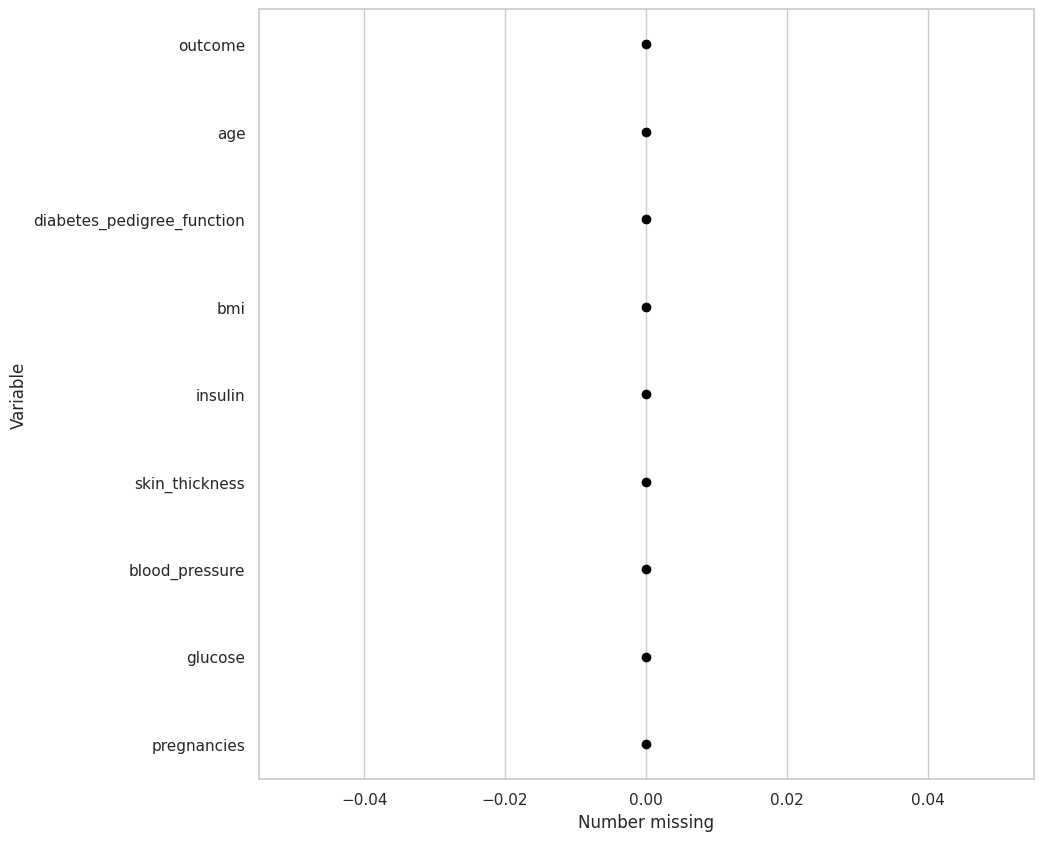

In [58]:
diabetes_df.missing.missing_variable_plot()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


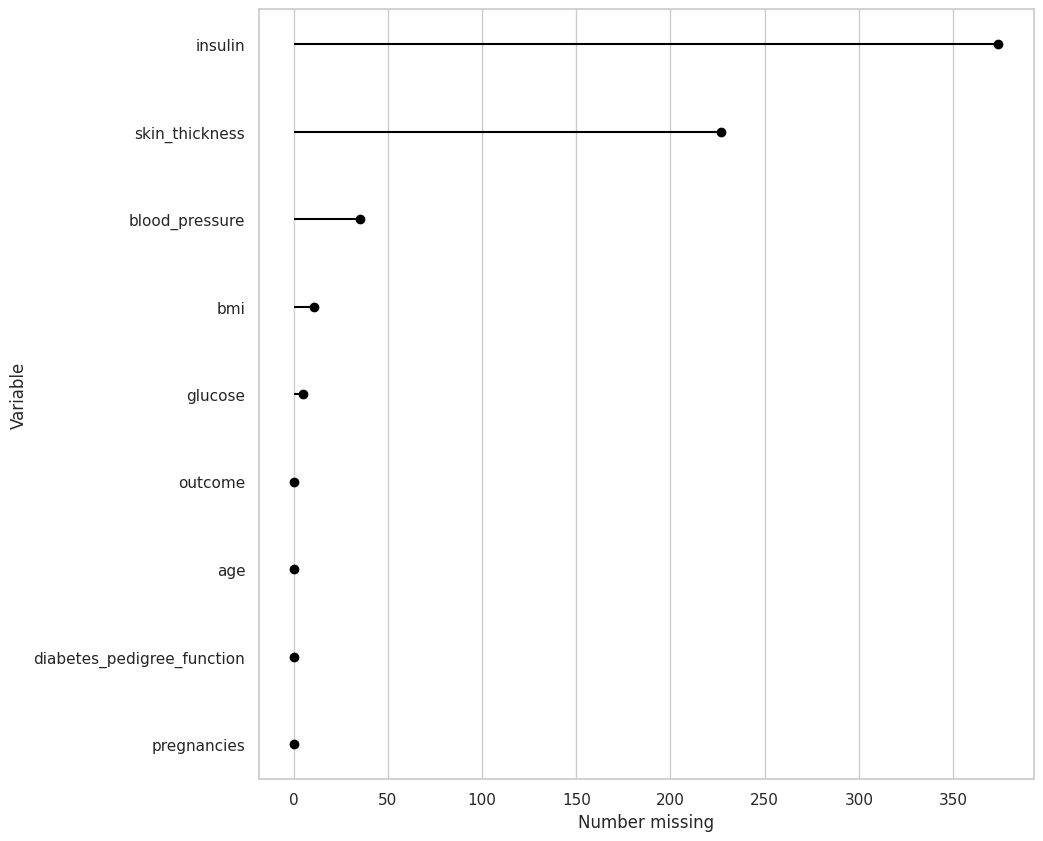

In [59]:
diabetes_df[diabetes_df.columns[1:6]] = diabetes_df[diabetes_df.columns[1:6]].replace(0, np.nan)
diabetes_df.missing.missing_variable_plot()

### _Missing Completely At Random_ (MCAR)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

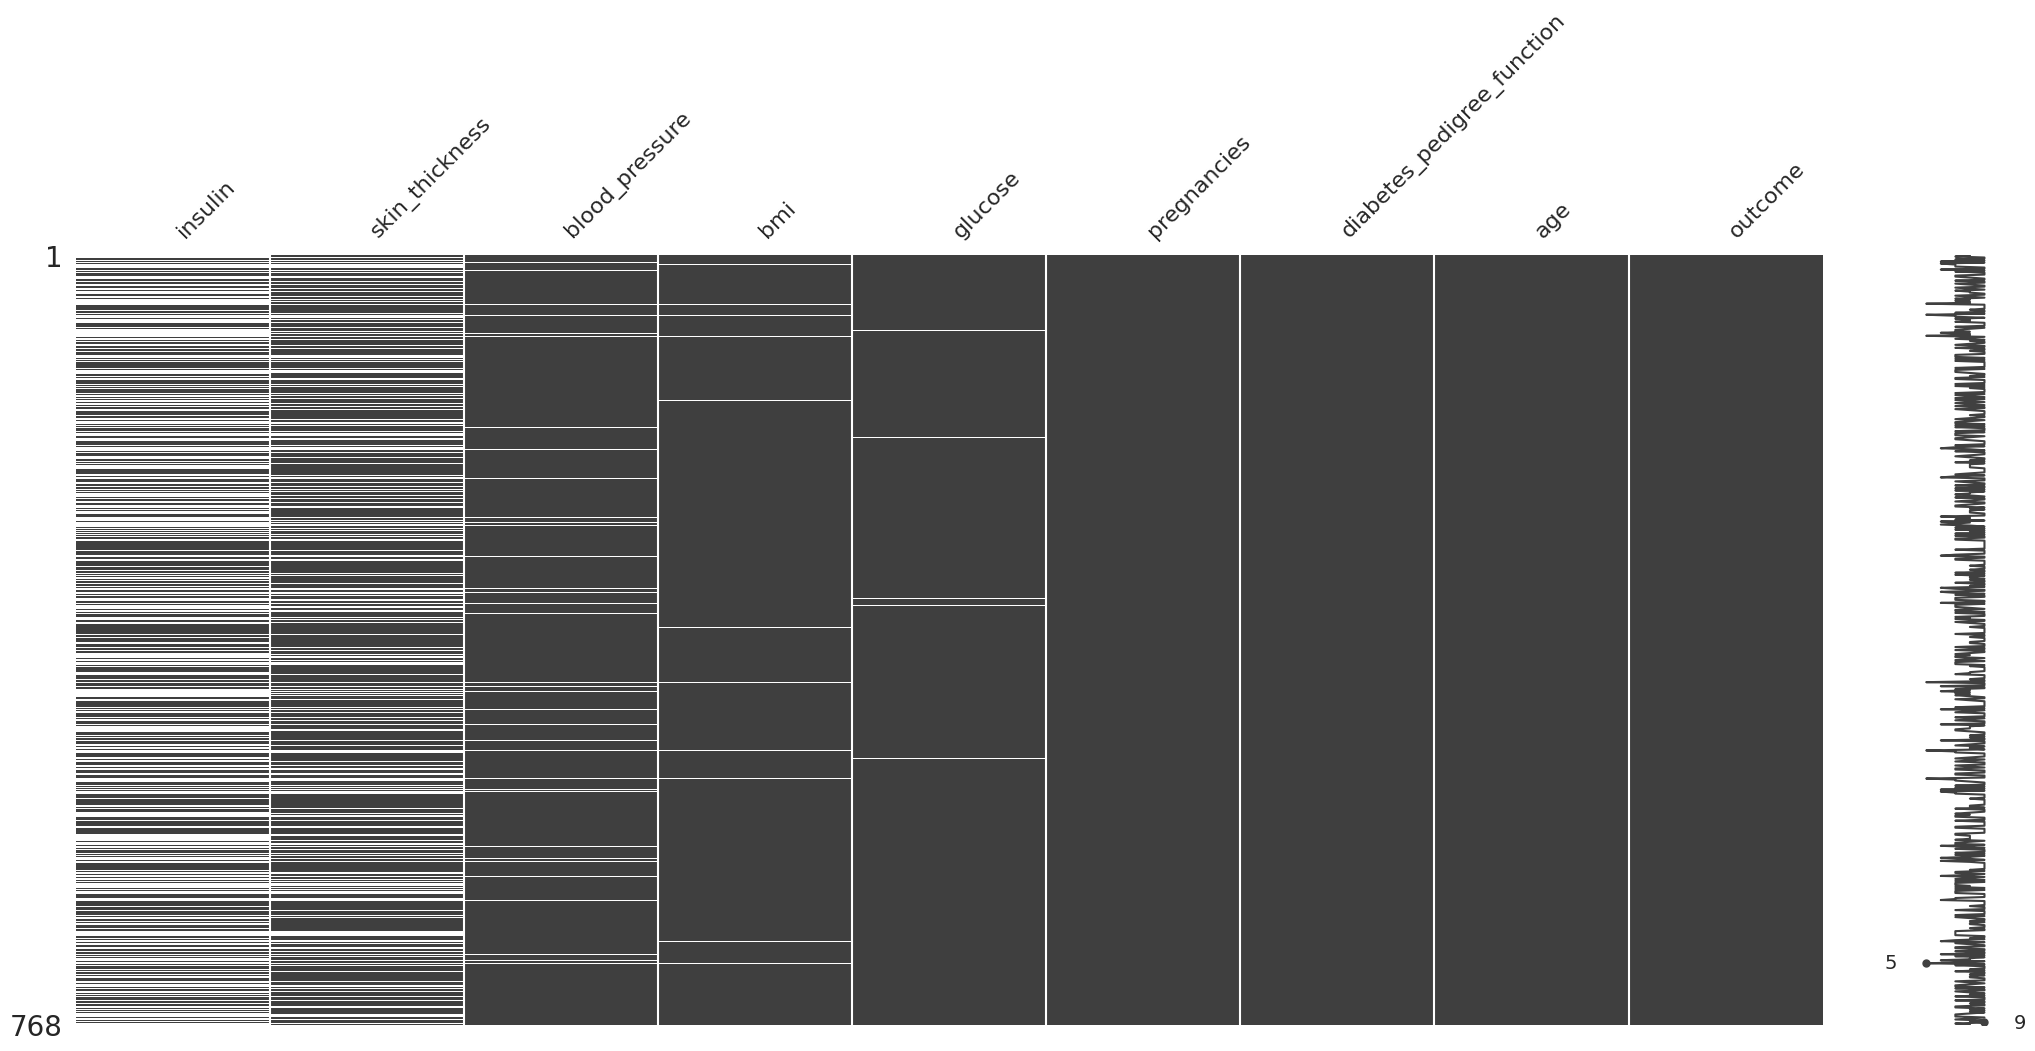

In [60]:
(
    diabetes_df
    .missing.sort_variables_by_missingness()
    .pipe(missingno.matrix)
)

### _Missing At Random_ (MAR)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

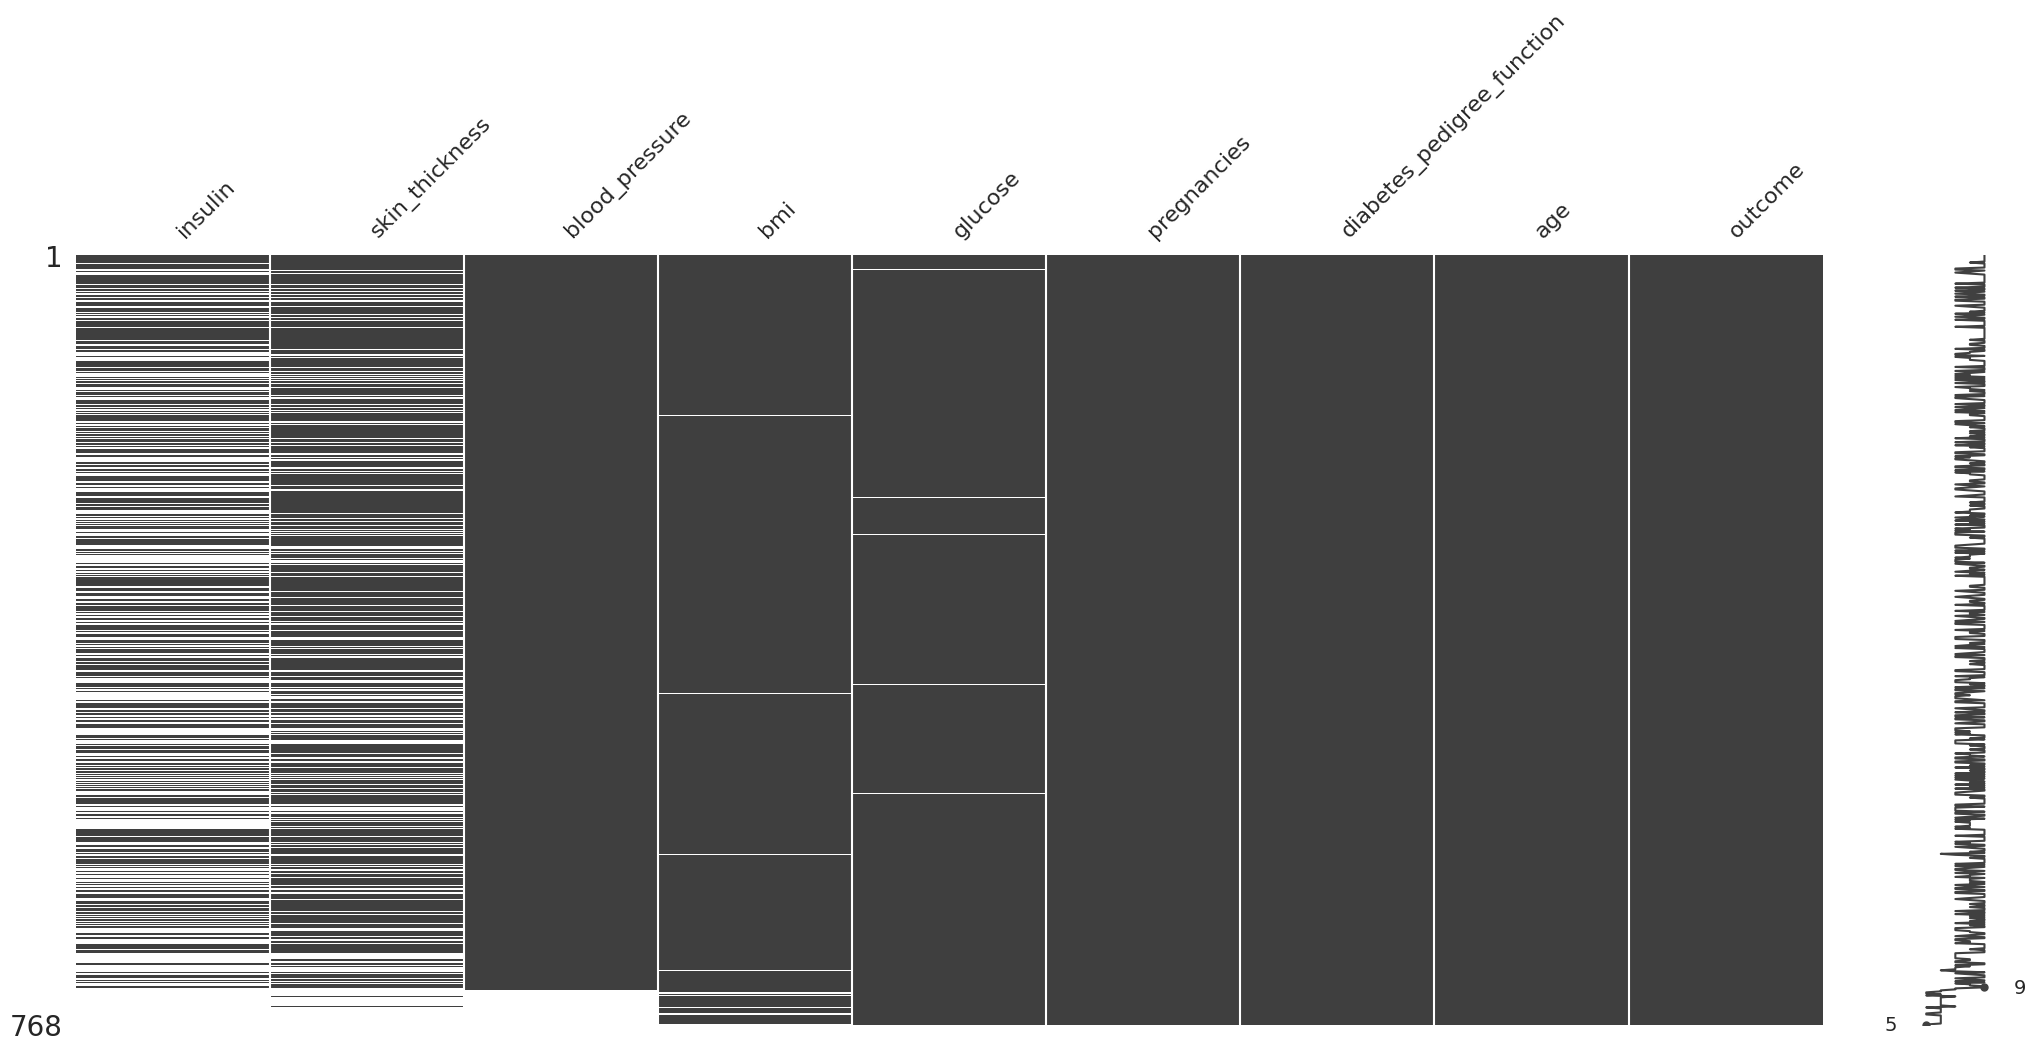

In [61]:
(
    diabetes_df
    .missing.sort_variables_by_missingness()
    .sort_values(by = "blood_pressure")
    .pipe(missingno.matrix)
)

### _Missing Not At Random_ (MNAR)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

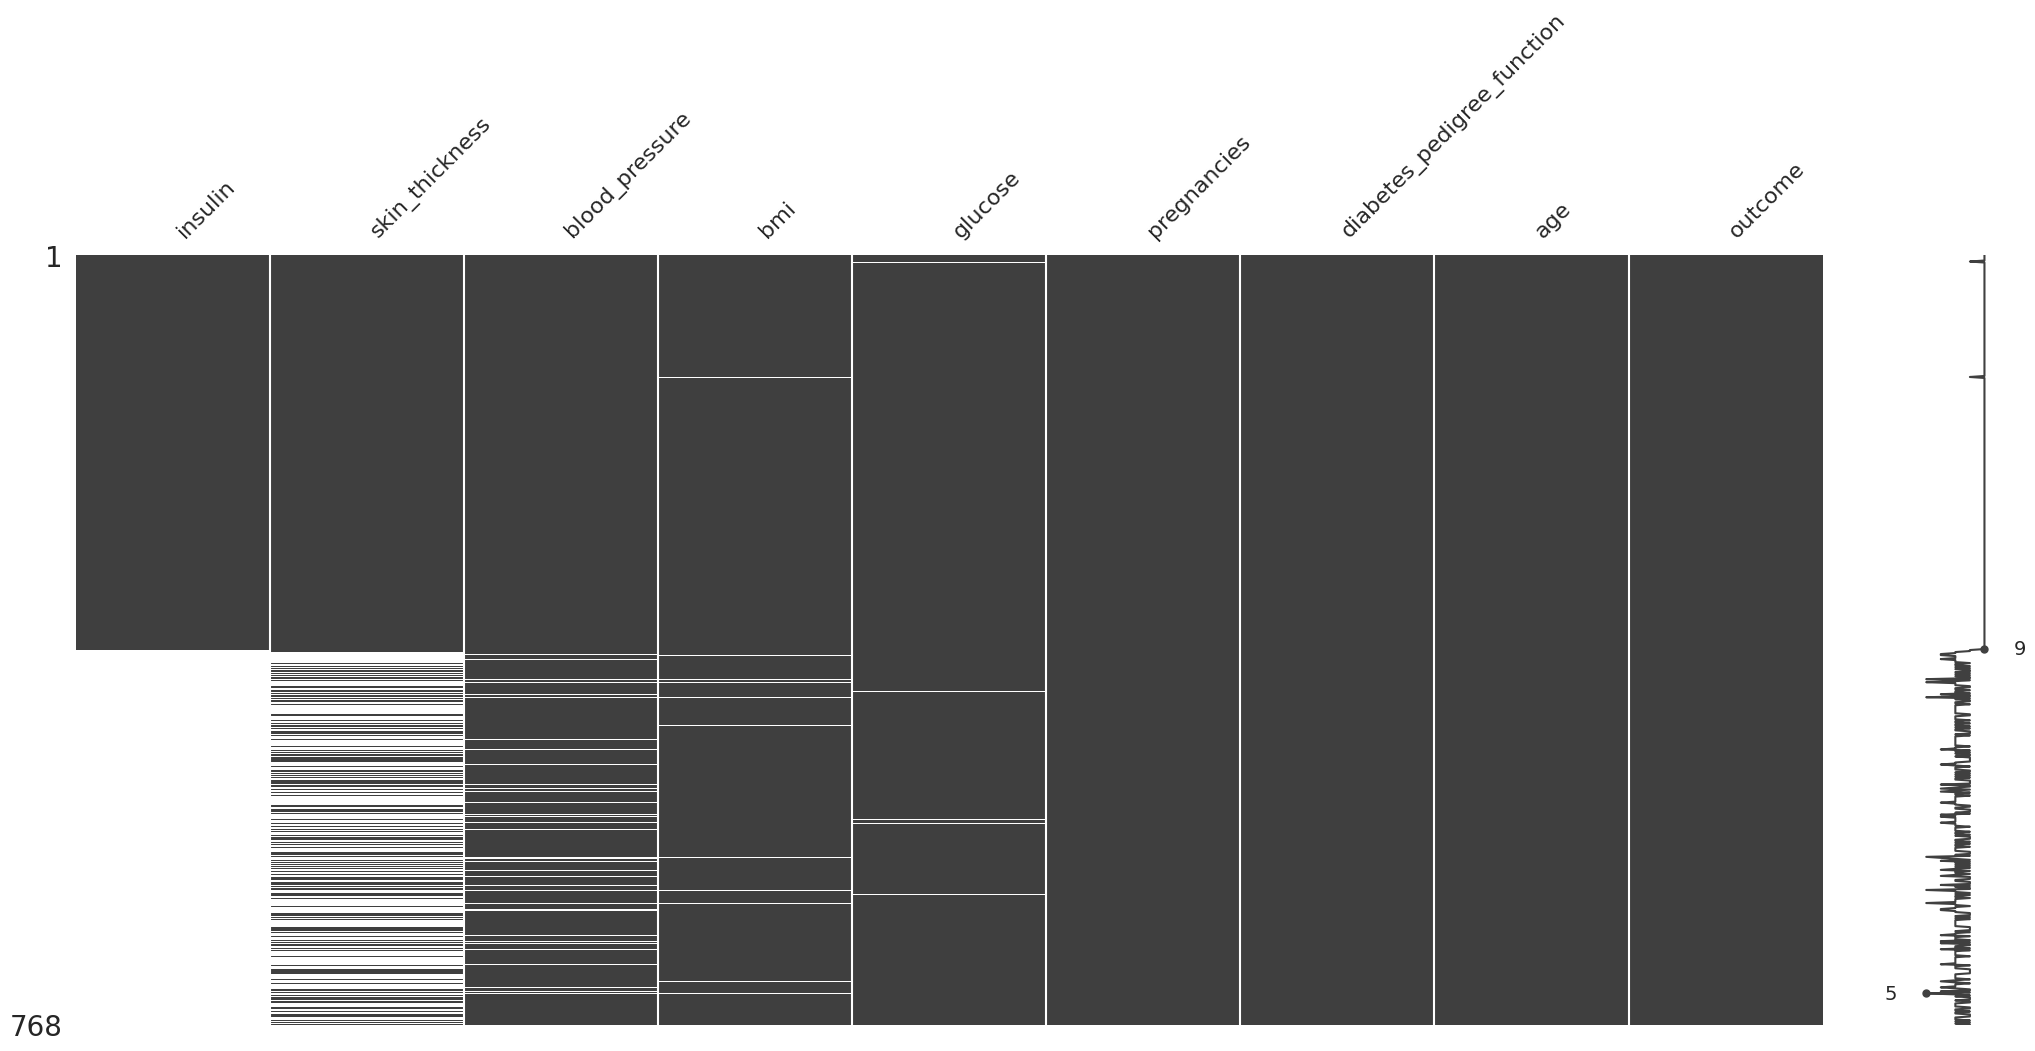

In [62]:
(
    diabetes_df
    .missing.sort_variables_by_missingness()
    .sort_values("insulin")
    .pipe(missingno.matrix)
)

**Concept and application of the shadow matrix (_i.e._, _shadow matrix_)**

 **Building the shadow matrix**

In [63]:
(
    riskfactors_df
    .isna()
    .replace({
        False: "Not missing",
        True: "Missing"
    })
    .add_suffix("_NA")
    .pipe(
        lambda shadow_matrix: pd.concat(
            [riskfactors_df, shadow_matrix],
            axis="columns"
        )
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100_NA,smoke_days_NA,smoke_stop_NA,smoke_last_NA,diet_fruit_NA,diet_salad_NA,diet_potato_NA,diet_carrot_NA,diet_vegetable_NA,diet_juice_NA
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,Not missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Not missing,Not missing,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Not missing,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Not missing,Not missing,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing


**Use utility function `bind_shadow_matrix()`**

In [64]:
(
    riskfactors_df
    .missing
    .bind_shadow_matrix(only_missing = True)
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100_NA,smoke_days_NA,smoke_stop_NA,smoke_last_NA,diet_fruit_NA,diet_salad_NA,diet_potato_NA,diet_carrot_NA,diet_vegetable_NA,diet_juice_NA
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,Not Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Not Missing,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Not Missing,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing


**Explore statistics using the new columns of the shadow matrix**

In [65]:
(
    riskfactors_df
    .missing
    .bind_shadow_matrix(only_missing=True)
    .groupby(["weight_lbs_NA"])
    ["age"]
    .describe()
    .reset_index()
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,weight_lbs_NA,count,mean,std,min,25%,50%,75%,max
0,Missing,10.0,60.100000,13.706851,37.0,52.25,62.5,65.0,82.0
1,Not Missing,235.0,58.021277,17.662904,7.0,47.50,59.0,70.0,97.0


**Visualization of missing values in a variable**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


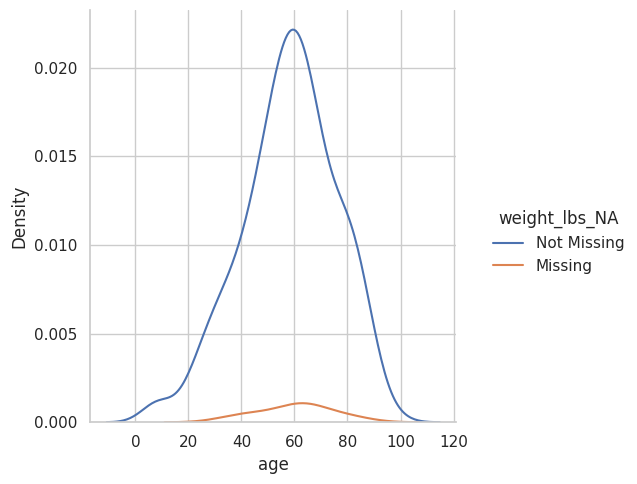

In [66]:
(
    riskfactors_df
    .missing
    .bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                x="age",
                hue="weight_lbs_NA",
                kind="kde"
            )
        )
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='weight_lbs_NA', ylabel='age'>

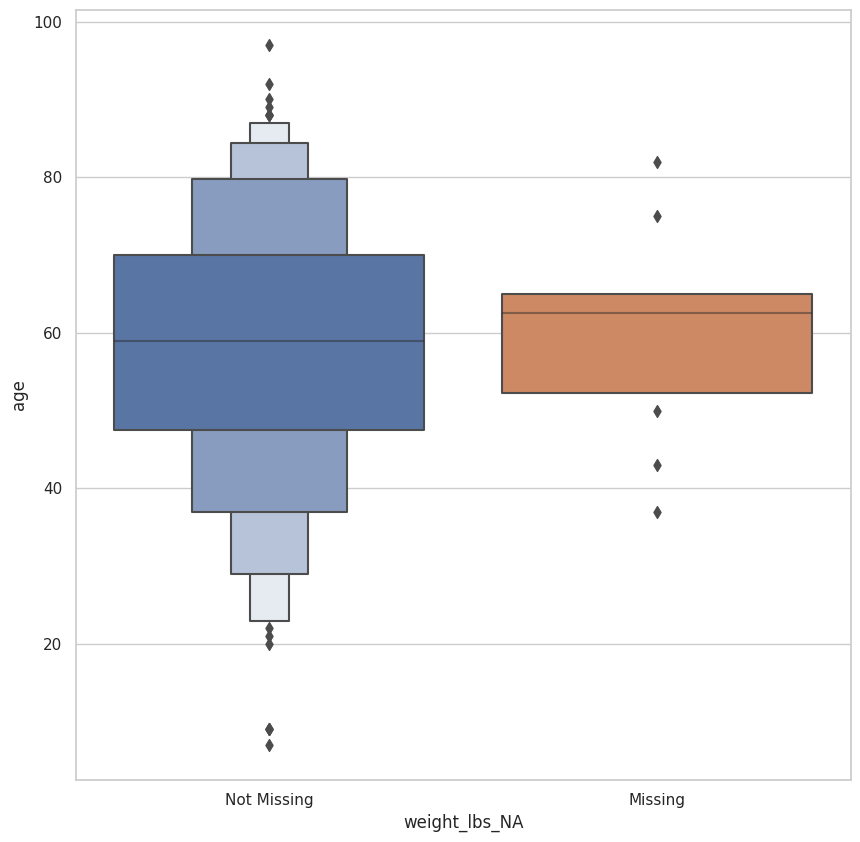

In [67]:
(
    riskfactors_df
    .missing
    .bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.boxenplot(
                data=df,
                x="weight_lbs_NA",
                y="age",
            )
        )
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


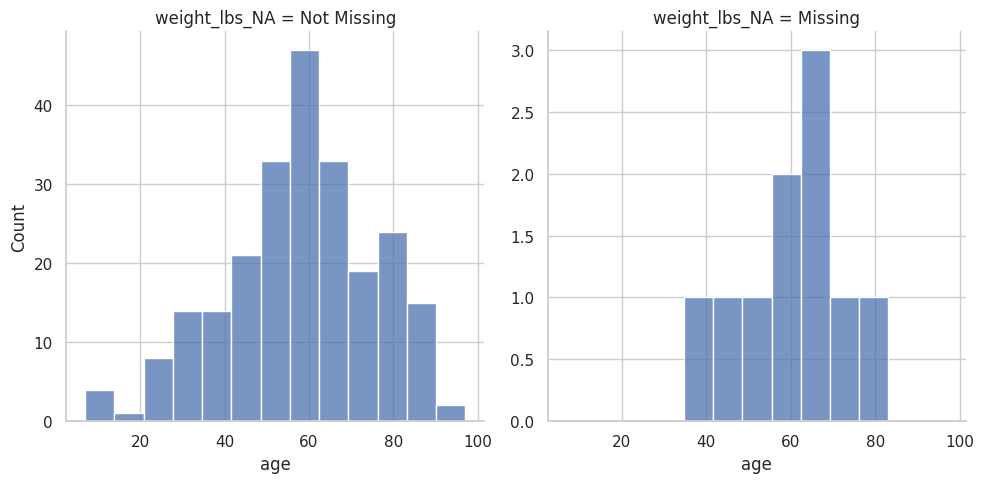

In [68]:
(
    riskfactors_df
    .missing
    .bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                x="age",
                col="weight_lbs_NA",
                facet_kws={
                    "sharey": False
                }
            )
        )
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


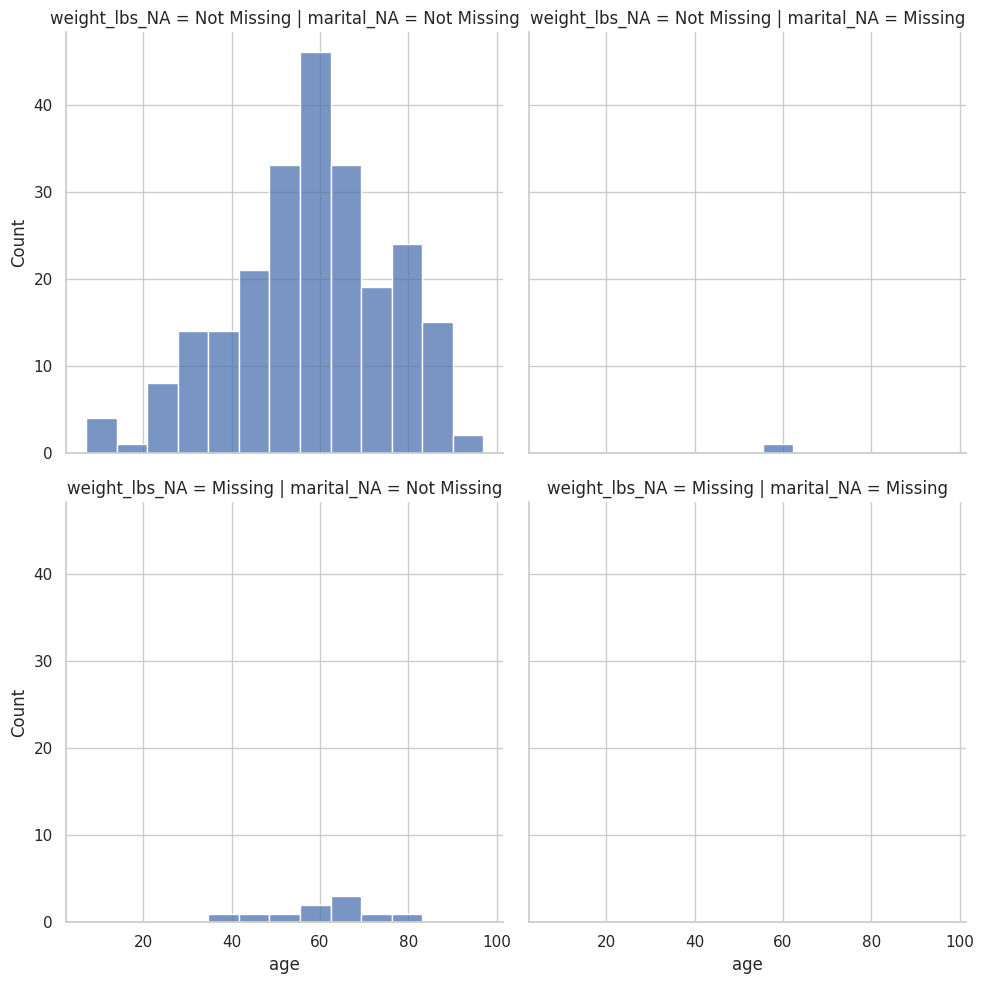

In [69]:
(
    riskfactors_df
    .missing
    .bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                x="age",
                col="marital_NA",
                row="weight_lbs_NA"
            )
        )
    )
)

**Visualization of missing values in two variables**

In [70]:
def column_fill_with_dummies(
    column: pd.Series,
    proportion_below: float=0.10,
    jitter: float=0.075,
    seed: int=42
) -> pd.Series:

    column = column.copy(deep=True)

    # Extract values metadata.
    missing_mask = column.isna()
    number_missing_values = missing_mask.sum()
    column_range = column.max() - column.min()

    # Shift data
    column_shift = column.min() - column.min() * proportion_below

    # Create the "jitter" (noise) to be added around the points.
    np.random.seed(seed)
    column_jitter = (np.random.rand(number_missing_values) - 2) * column_range * jitter

    # Save new dummy data.
    column[missing_mask] = column_shift + column_jitter

    return column

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='weight_lbs', ylabel='height_inch'>

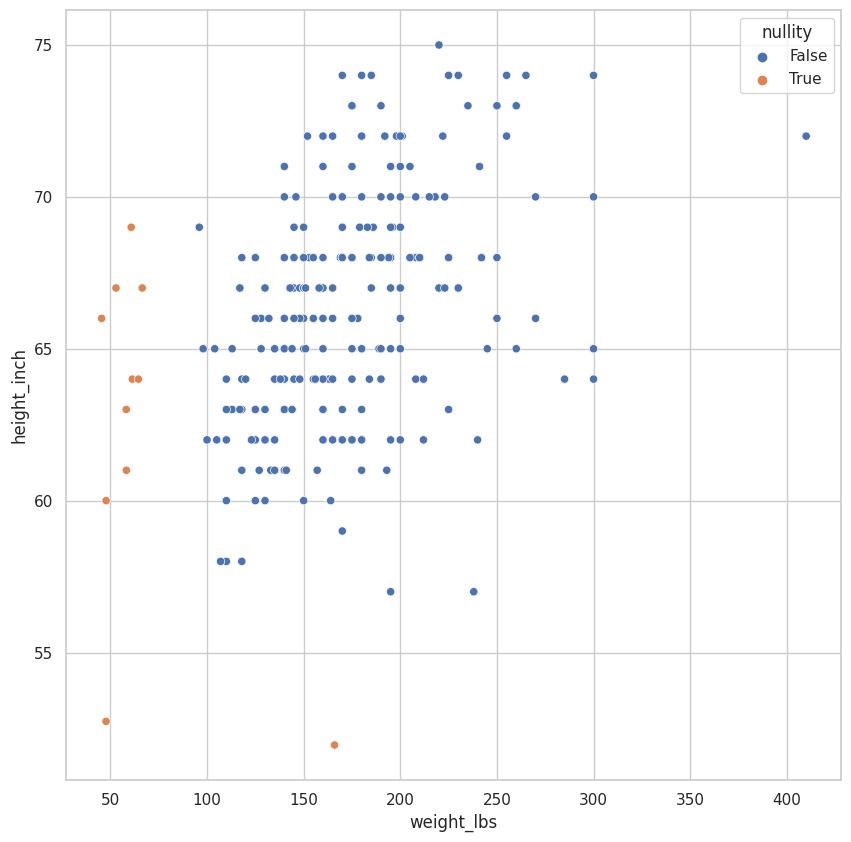

In [71]:
plt.figure(figsize=(10, 10))

(
    riskfactors_df
    .select_dtypes(
        exclude="category"
    )
    .pipe(
        lambda df: df[df.columns[df.isna().any()]]
    )
    .missing.bind_shadow_matrix(true_string=True, false_string=False)
    .apply(
        lambda column: column if "_NA" in column.name else column_fill_with_dummies(column, proportion_below=0.05, jitter=0.075)
    )
    .assign(
        nullity=lambda df: df.weight_lbs_NA | df.height_inch_NA
    )
    .pipe(
        lambda df: (
            sns.scatterplot(
                data=df,
                x="weight_lbs",
                y="height_inch",
                hue="nullity"
            )
        )
    )
)

Nullity correlation

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

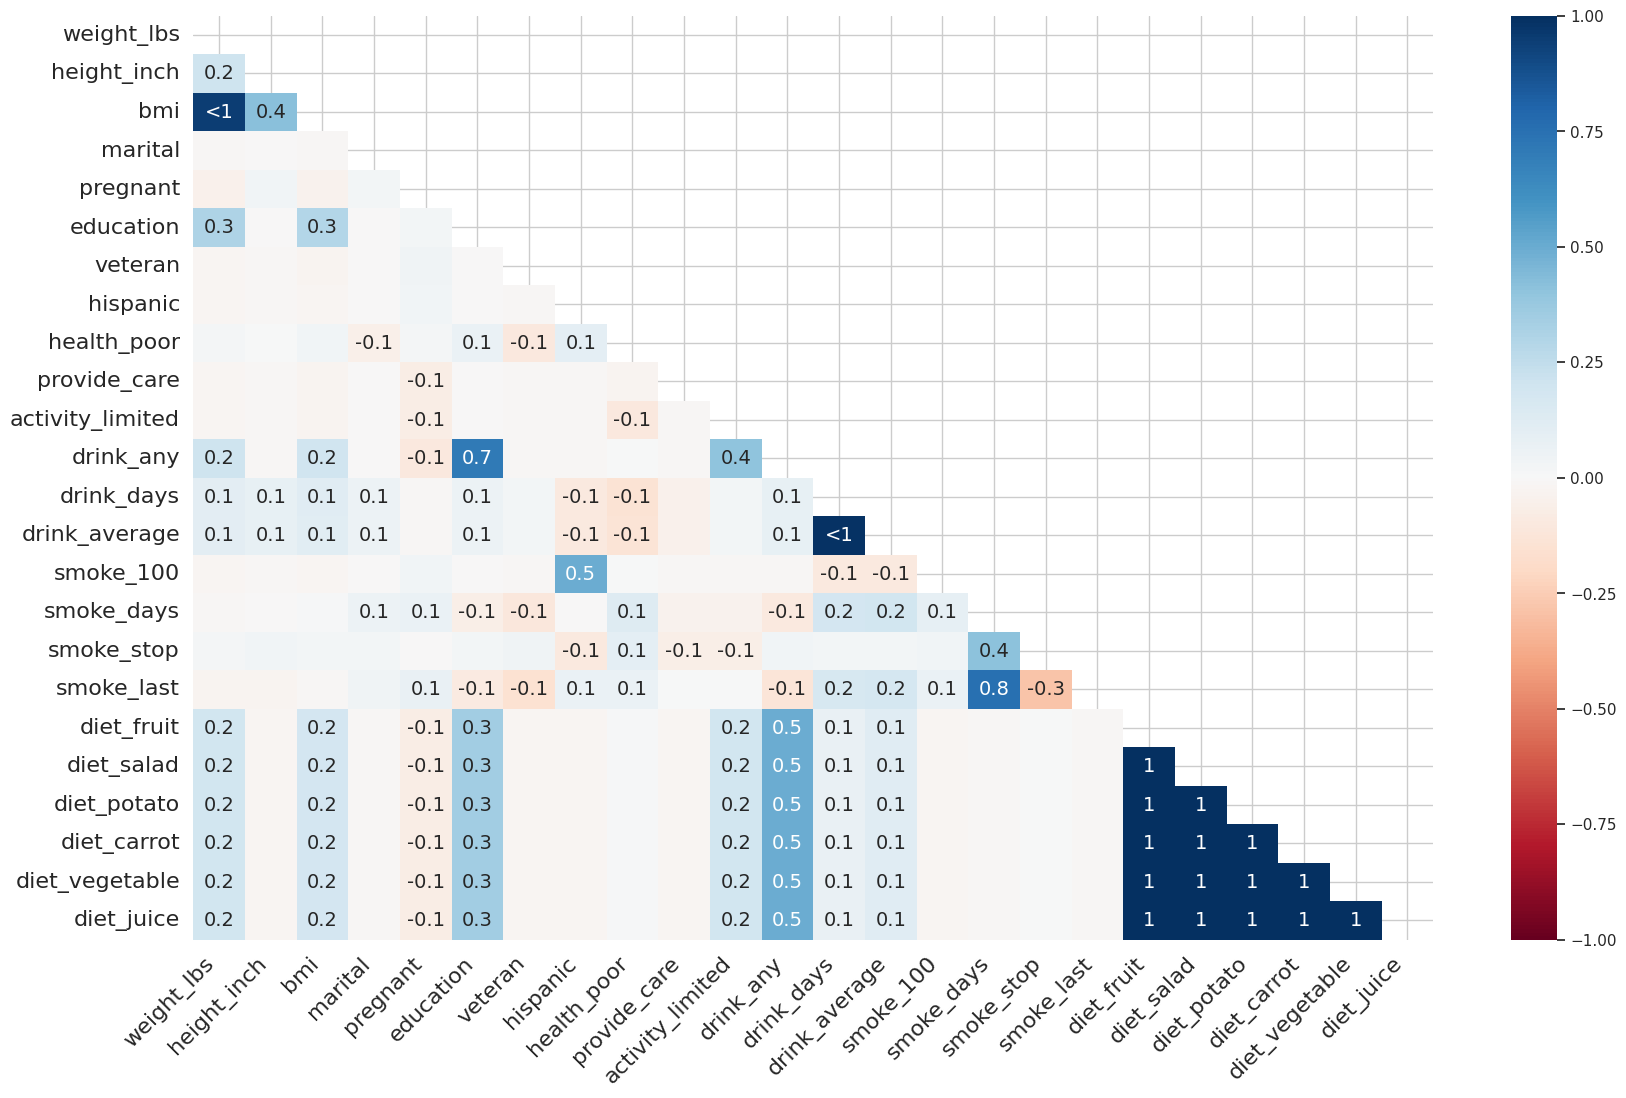

In [72]:
missingno.heatmap(
    df=riskfactors_df
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

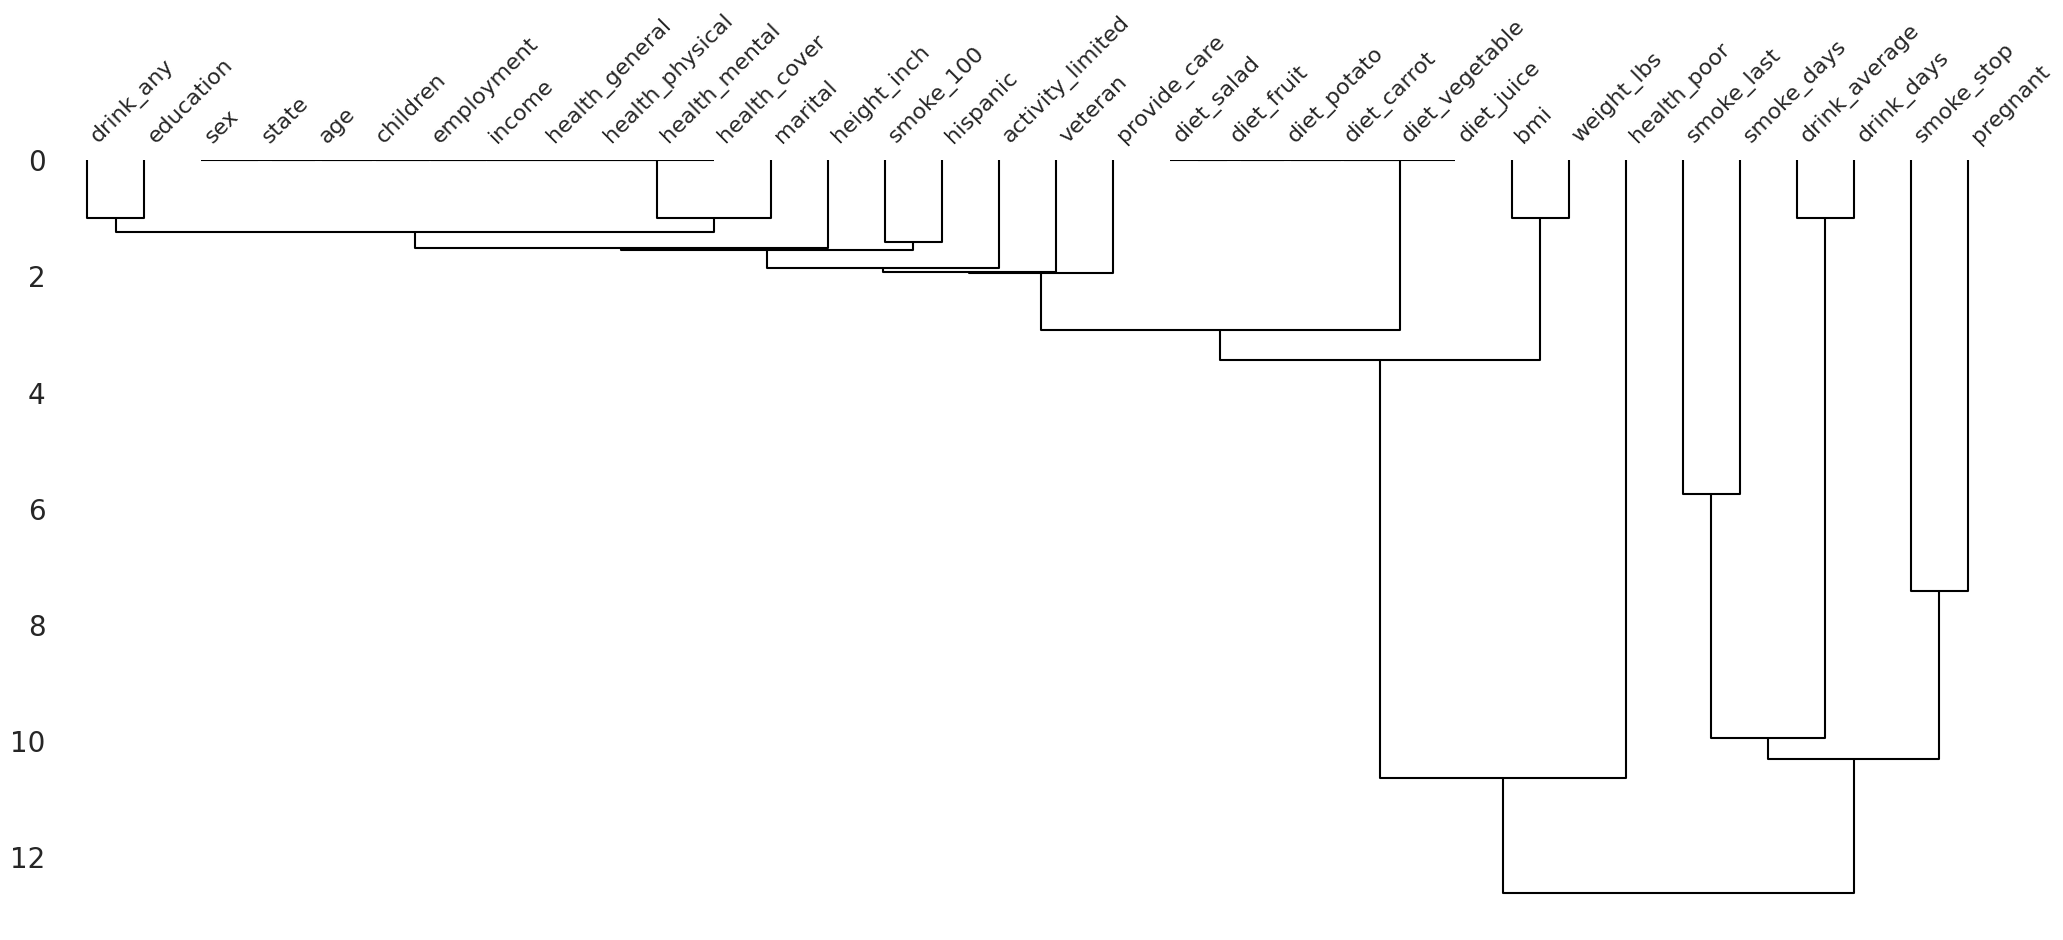

In [73]:
missingno.dendrogram(
    df=riskfactors_df
)

**Elimination of missing values**

**First, observe the total number of observations and variables in your dataset.**

In [74]:
riskfactors_df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(245, 34)

**_Pairwise deletion_ (Pairwise deletion)**

In [75]:
(
    riskfactors_df
    .weight_lbs
    .mean()
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


174.26808510638298

In [76]:
riskfactors_df.weight_lbs.size, riskfactors_df.weight_lbs.count()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(245, 235)

In [77]:
riskfactors_df.weight_lbs.mean(skipna=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


nan

**_Listwise Deletion or Complete Case_ (Listwise Deletion or Complete Case)**

**Based on 1 column**

In [78]:
(
    riskfactors_df
    .dropna(
        subset=["weight_lbs"],
        how="any"
    )
    .shape
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(235, 34)

**Based on 2 or more columns**

In [79]:
(
    riskfactors_df
    .dropna(
        subset=["weight_lbs", "height_inch"],
        how="any"
    )
    .shape
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(234, 34)

In [83]:
(
    riskfactors_df
    .dropna(
        subset=["weight_lbs", "height_inch"],
        how="all"
    )
    .shape
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(244, 34)

**Graphical representation after eliminating missing values**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

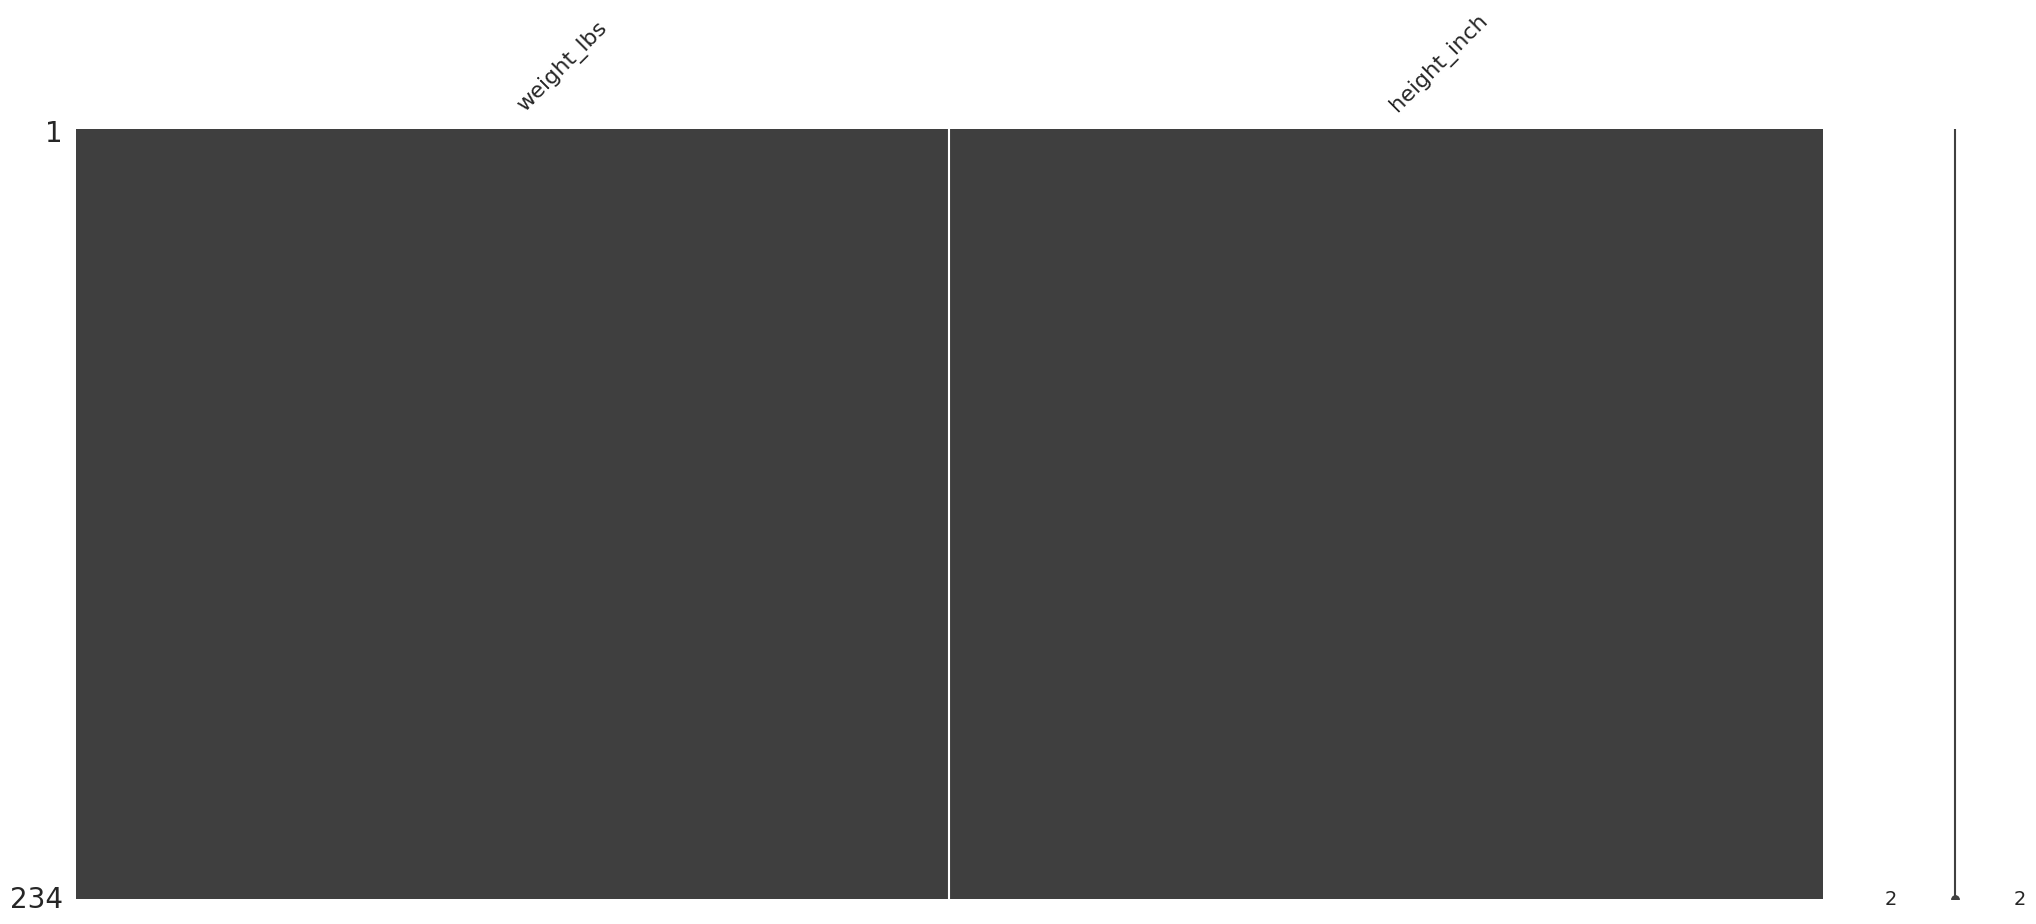

In [84]:
(
    riskfactors_df
    .dropna(
        subset=["weight_lbs", "height_inch"],
        how="any"
    )
    .select_columns(["weight_lbs", "height_inch"])
    .pipe(
        lambda df: missingno.matrix(df)
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

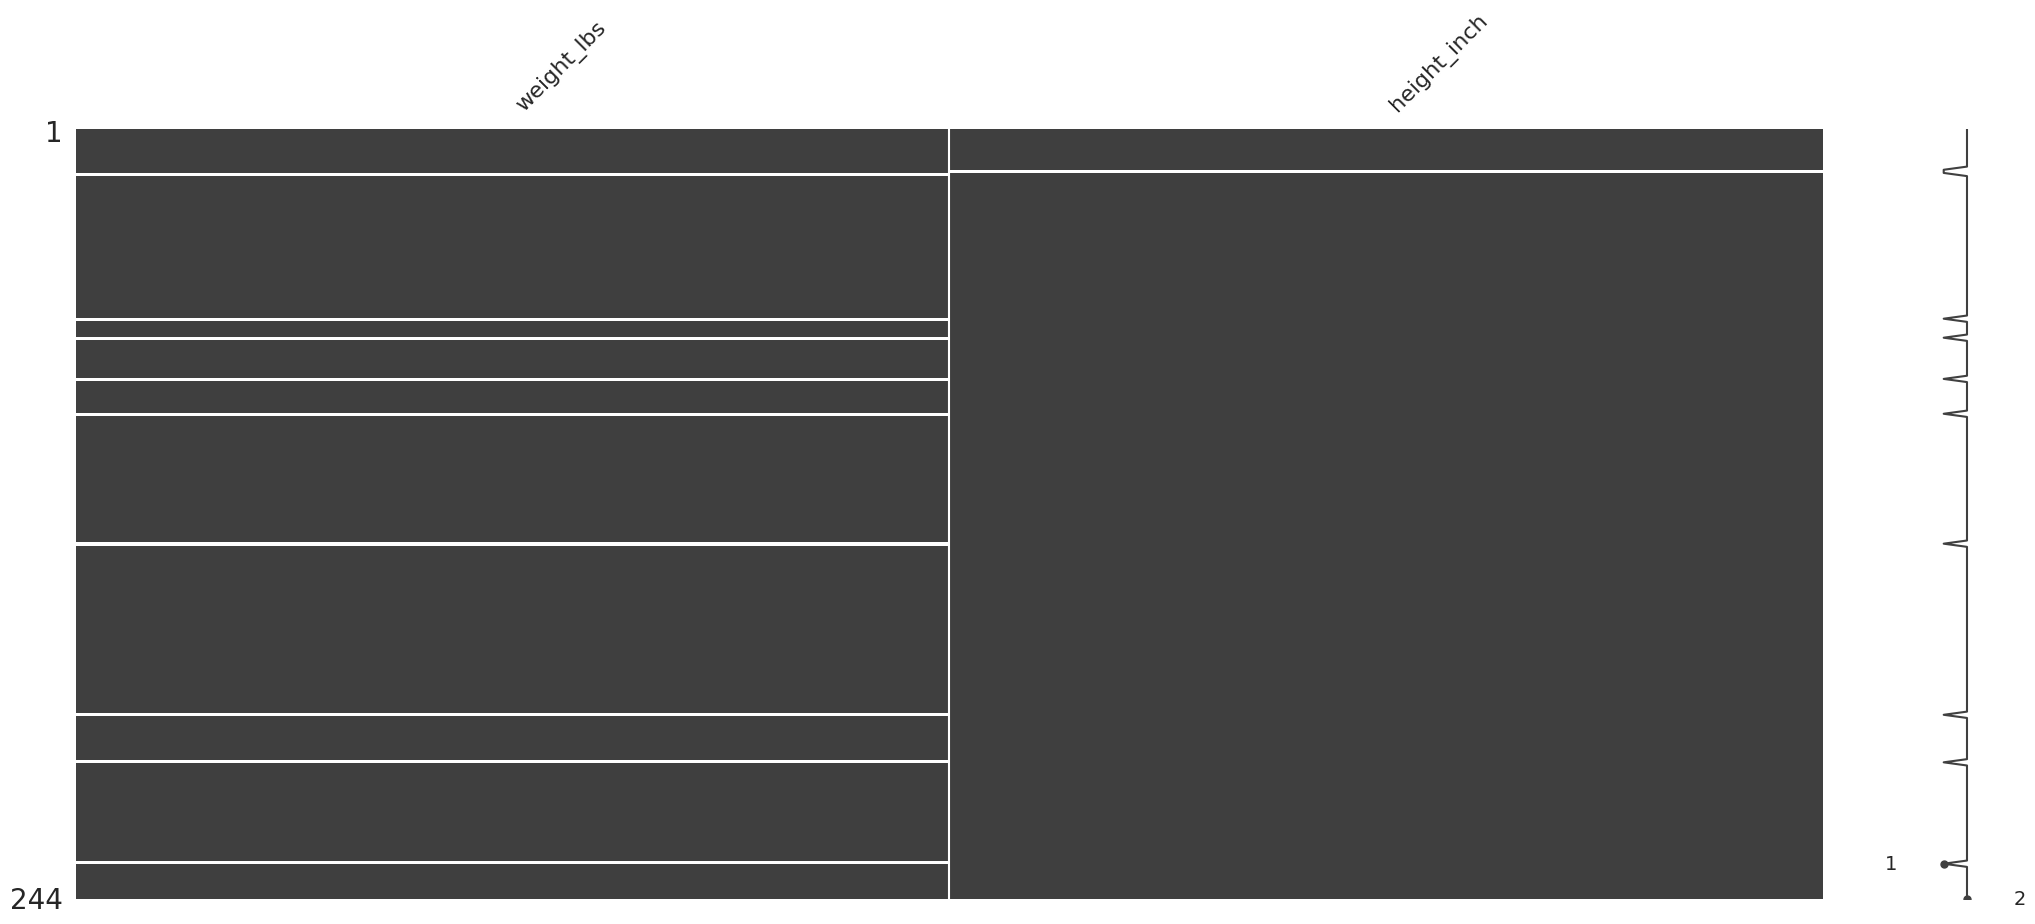

In [82]:
(
    riskfactors_df
    .dropna(
        subset=["weight_lbs", "height_inch"],
        how="all"
    )
    .select_columns(["weight_lbs", "height_inch"])
    .pipe(
        lambda df: missingno.matrix(df)
    )
)

**Basic imputation of missing values.**

**Context-based imputation.**

In [85]:
implicit_to_explicit_df = pd.DataFrame(
    data={
        "name": ["lynn", np.nan, "zelda", np.nan, "shadowsong", np.nan],
        "time": ["morning", "afternoon", "morning", "afternoon", "morning", "afternoon",],
        "value": [350, 310, 320, 350, 310, 320]
    }
)

implicit_to_explicit_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,time,value
0,lynn,morning,350
1,NaN,afternoon,310
2,zelda,morning,320
3,NaN,afternoon,350
4,shadowsong,morning,310
5,NaN,afternoon,320


In [86]:
implicit_to_explicit_df.ffill()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,time,value
0,lynn,morning,350
1,lynn,afternoon,310
2,zelda,morning,320
3,zelda,afternoon,350
4,shadowsong,morning,310
5,shadowsong,afternoon,320


**Single-value imputation.**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1000x1000 with 0 Axes>

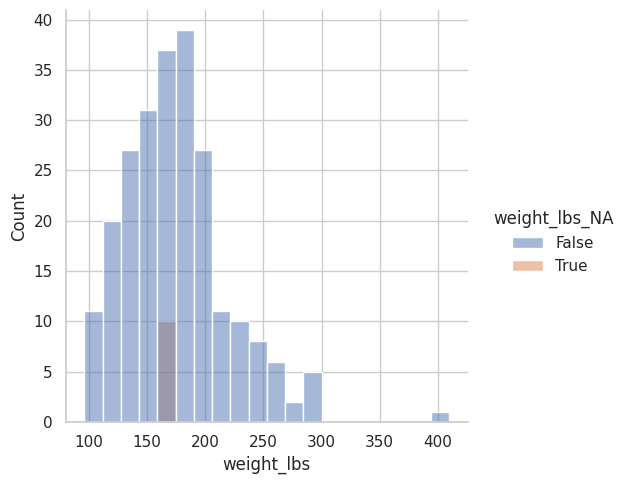

In [87]:
plt.figure(figsize=(10, 10))

(
    riskfactors_df
    .select_columns("weight_lbs", "height_inch", "bmi")
    .missing.bind_shadow_matrix(true_string=True, false_string=False)
    .apply(
        axis="rows",
        func=lambda column: column.fillna(column.mean()) if "_NA" not in column.name else column
    )
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                x="weight_lbs",
                hue="weight_lbs_NA"
            )
        )
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='weight_lbs', ylabel='height_inch'>

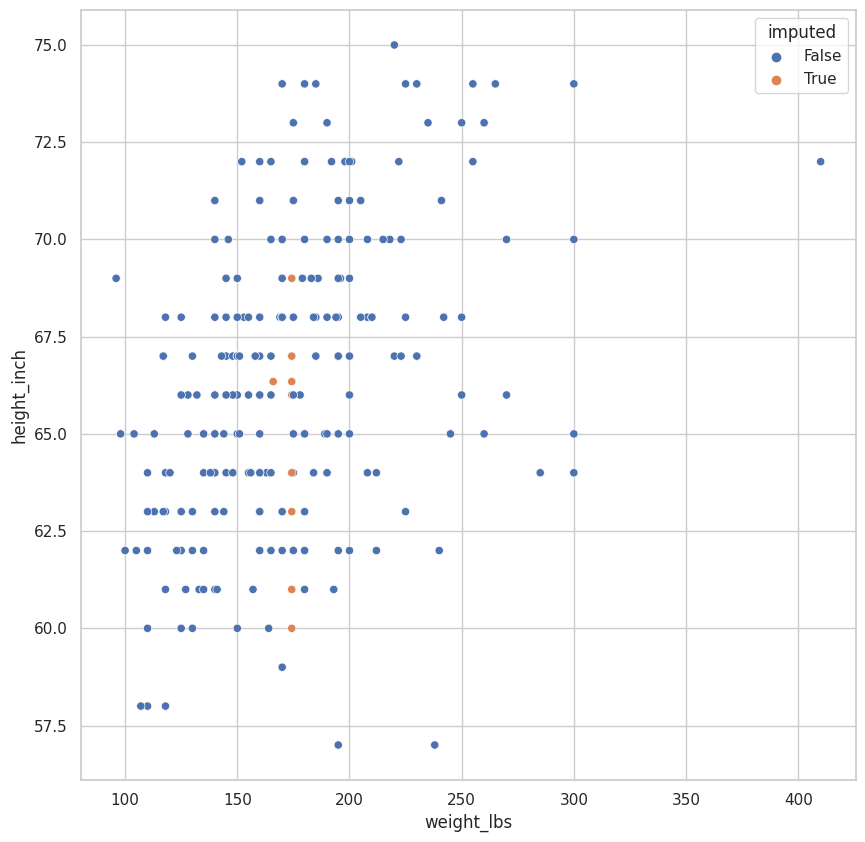

In [88]:
plt.figure(figsize=(10, 10))

(
    riskfactors_df
    .select_columns("weight_lbs", "height_inch", "bmi")
    .missing.bind_shadow_matrix(true_string=True, false_string=False)
    .apply(
        axis="rows",
        func=lambda column: column.fillna(column.mean()) if "_NA" not in column.name else column
    )
    .assign(
        imputed=lambda df: df.weight_lbs_NA | df.height_inch_NA
    )
    .pipe(
        lambda df: (
            sns.scatterplot(
                data=df,
                x="weight_lbs",
                y="height_inch",
                hue="imputed"
            )
        )
    )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1000x1000 with 0 Axes>

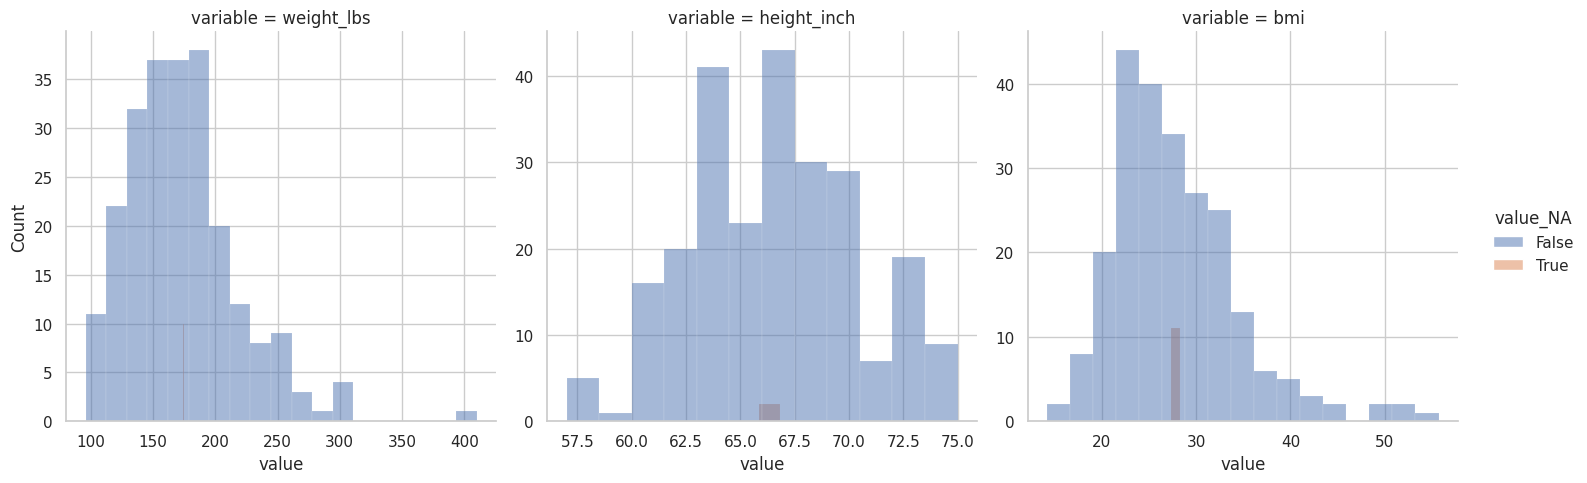

In [89]:
plt.figure(figsize=(10, 10))

(
    riskfactors_df
    .select_columns("weight_lbs", "height_inch", "bmi")
    .missing.bind_shadow_matrix(true_string=True, false_string=False)
    .apply(
        axis="rows",
        func=lambda column: column.fillna(column.mean())
        if "_NA" not in column.name
        else column,
    )
    .pivot_longer(
        index="*_NA"
    )
    .pivot_longer(
        index=["variable", 'value'],
        names_to="variable_NA",
        values_to="value_NA"
    )
    .assign(
        valid=lambda df: df.apply(axis="columns", func=lambda column: column.variable in column.variable_NA)
    )
    .query("valid")
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                x="value",
                hue="value_NA",
                col="variable",
                common_bins=False,
                facet_kws={
                    "sharex": False,
                    "sharey": False
                }
            )
        )
    )
)


In [90]:
session_info.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
